<a href="https://colab.research.google.com/github/mannodiarun/MSE570/blob/perovs_dft_ml/Perovs-DFT-ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project Description**

This project uses a combination of high-throughput density functional theory (DFT) data and experimental data on halide perovskite alloys to train predictive machine learning (ML) models using a variety of regression algorithms for properties of interest.

DFT calculations are performed at two levels of theory: GGA-PBE (referred to as PBE henceforth) and HSE06 (referred to as HSE henceforth), leading to a DFT dataset of ~ 800 points. Three properties are computed: the decomposition energy (in eV per formula unit), the band gap (in eV), and the spectroscopic limited maximum efficiency (SLME, in fraction, indicating a theoretical limit for photovoltaic power conversion efficiency). Experimental data (band gap and PV efficiency) for around 100 points, collected from the literature, are further added to the dataset. Every data point or compound is identified using an Index and a Formula. Two types of input descriptors are defined (to be used for training input -> output predictive models): a composition vector (14 dim) and a elemental properties vector (36 dim); one-hot encoded vectors representing the perovskite phase (cubic, tetragonal, orthorhombic, or hexagonal) and the source of data (PBE, HSE, Expt) are further added as descriptors. The data are divided into 4 types: PBE only, HSE only, PBE+HSE, and PBE+HSE+Expt.

This notebook calls relevant python packages, reads the DFT and/or experimental data, performs data visualization, and then has different sections for a variety of ML treatments including Pearson coefficients of linear correlation between descriptors and properties followed by regression models using elasticnet regression, random forest regression, and kernel ridge regression.


Relevant references:
1. J. Yang, P. Manganaris, and A. Mannodi-Kanakkithodi, "Discovering Novel Halide Perovskite Alloys using Multi-Fidelity Machine Learning and Genetic Algorithm", Journal of Chemical Physics. 160, 064114 (2024).
2. J. Yang, P. Manganaris, A. Mannodi-Kanakkithodi, "A High-Throughput Computational Dataset of Halide Perovskite Alloys", Digital Discovery. 2, 856-870 (2023).
3. J. Yang, A. Mannodi-Kanakkithodi, "High-Throughput Computations and Machine Learning for Halide Perovskite Discovery", MRS Bulletin. 47, 940–948 (2022).
4. A. Mannodi-Kanakkithodi, M. K. Y. Chan, "Data-Driven Design of Novel Halide Perovskite Alloys", Energy and Environmental Science. 15, 1930–1949 (2022).


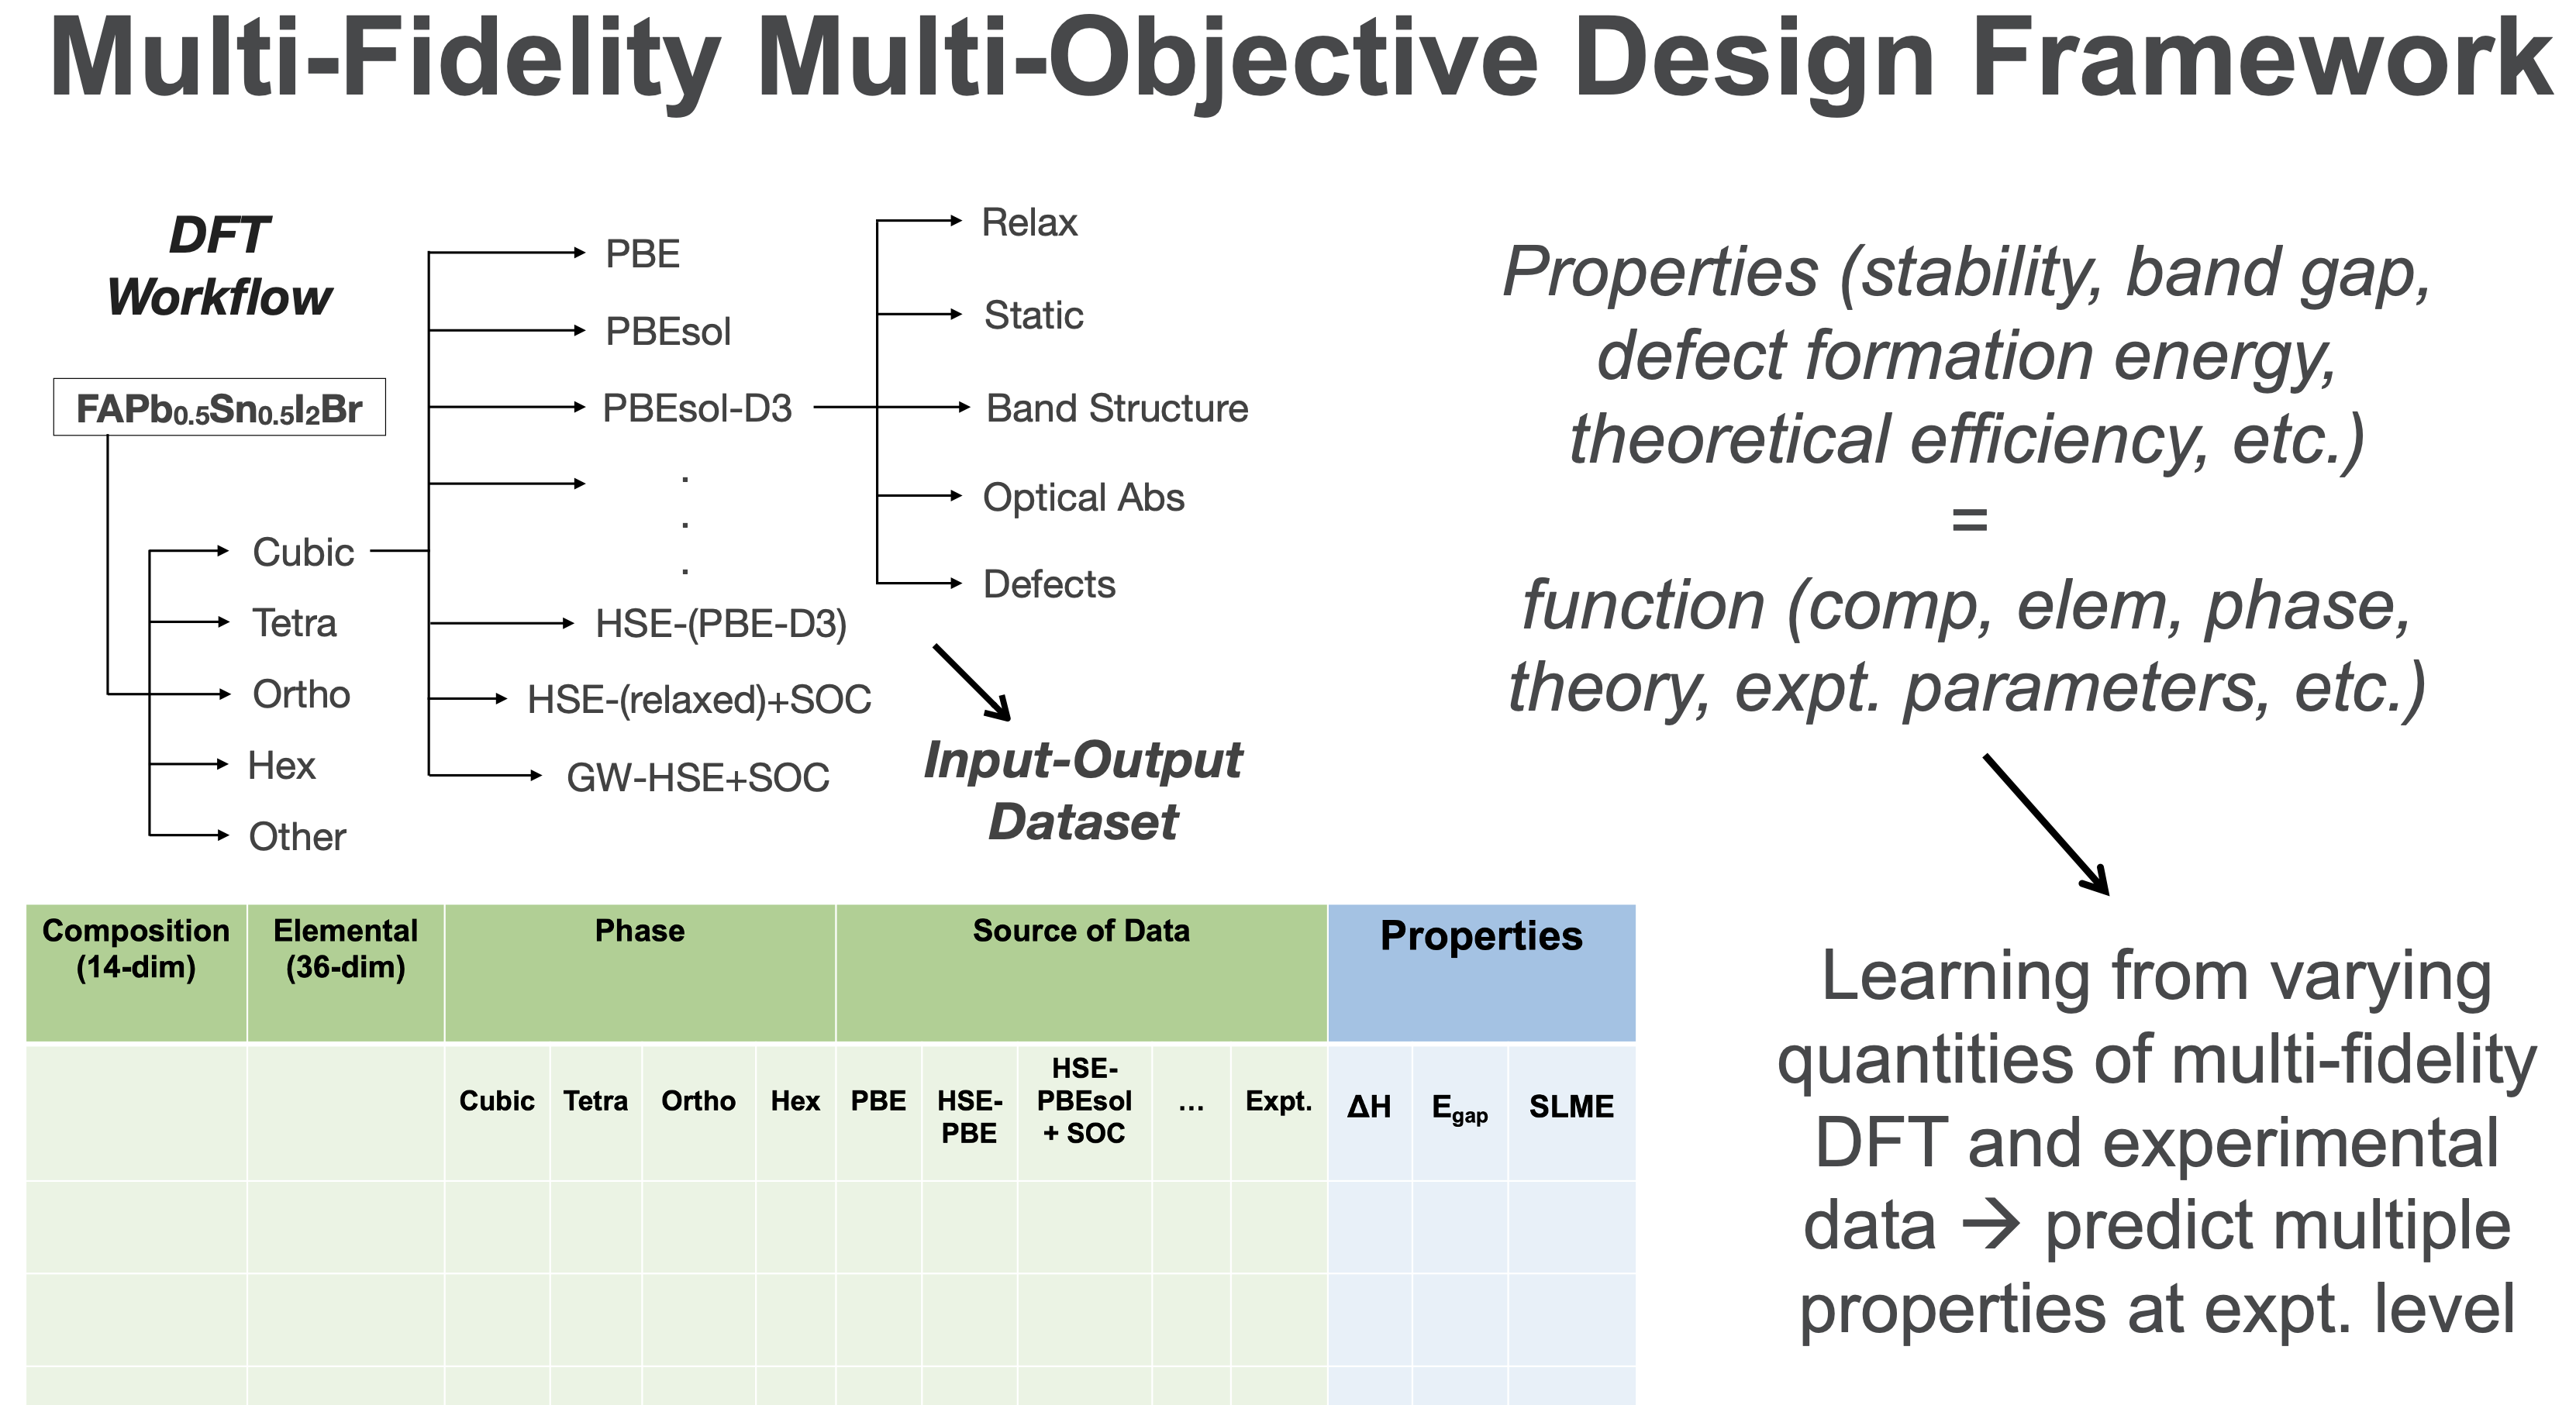

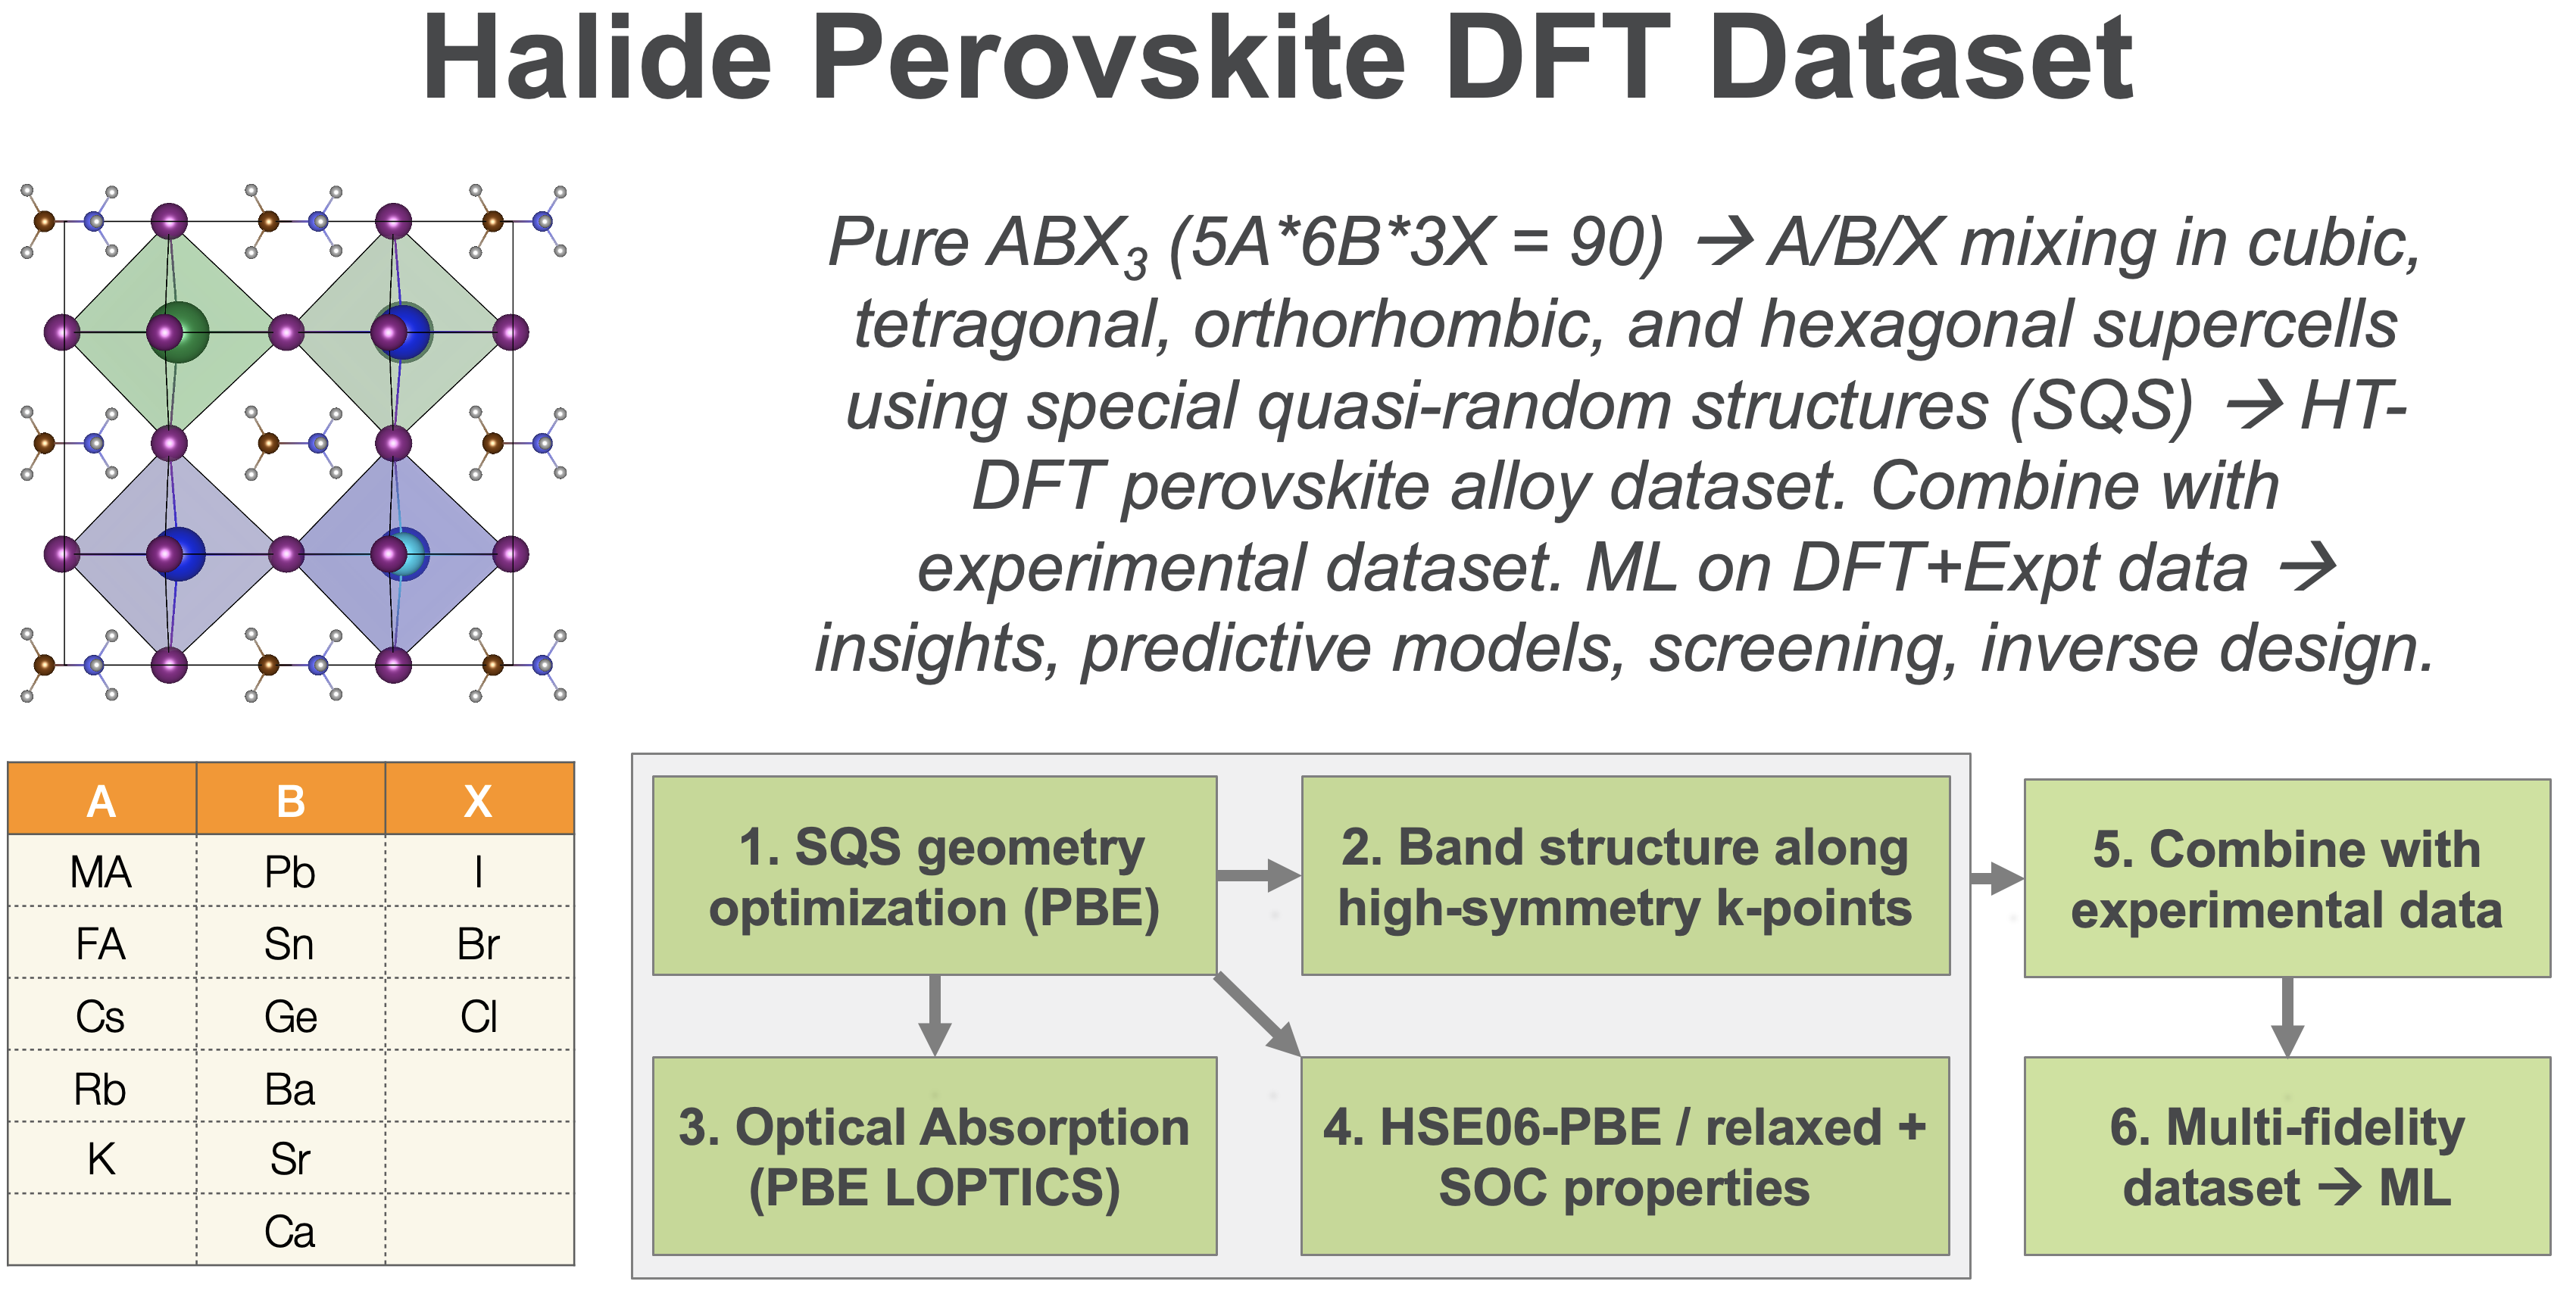

The overall goal of this project is to learn from a multi-fidelity dataset (properties from DFT-PBE, DFT-HSE, and Experiment) of halide perovskite alloys in a variety of prototypical phases, and obtain predictive models for multiple properties at different fidelities. Best models are subsequently used for large-scale prediction and inverse design.

The main part of the tutorial begins here.

In [1]:
import numpy as np
import csv
import copy
import random
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from pandas import read_csv
import sklearn
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared
import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings("ignore")


In [25]:
###  Read Data  ###


Operation = 'Regression'
#Operation = 'GA'

##  Choose Dataset Type  ##
#Data = 'PBE'
Data = 'HSE'
#Data = 'PBE_and_HSE'
#Data = 'PBE_HSE_Expt'

##  Choose Descriptor Type  ##
#Desc = 'Composition Only'
#Desc = 'Elemental Only'
Desc = 'Composition and Elemental'



if Operation == 'Regression':

    if Data == 'PBE':
        !wget https://raw.githubusercontent.com/mannodiarun/MSE570/perovs_dft_ml/PBE_data.csv
        !wget https://raw.githubusercontent.com/mannodiarun/MSE570/perovs_dft_ml/Expt_desc.csv
        !wget https://raw.githubusercontent.com/mannodiarun/MSE570/perovs_dft_ml/Outside.csv
        D = read_csv('PBE_data.csv')
        df = pd.DataFrame(D)
        Index = df.Index
        Formula = df.Formula
        Decomp = df.Decomp
        Gap = df.Gap
        SLME = df.SLME
        Comp_desc = pd.DataFrame(D, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex'])
        Elem_desc = pd.DataFrame(D, columns=['Cubic', 'Tetra', 'Ortho', 'Hex', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
        All_desc = pd.DataFrame(D, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])

        D_2 = read_csv('Expt_desc.csv')
        df_2 = pd.DataFrame(D_2)
        Comp_desc_expt = pd.DataFrame(D_2, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex'])
        Elem_desc_expt = pd.DataFrame(D_2, columns=['Cubic', 'Tetra', 'Ortho', 'Hex', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
        All_desc_expt = pd.DataFrame(D_2, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])

        D_3 = read_csv('Outside.csv')
        df_3 = pd.DataFrame(D_3)
        Comp_desc_out = pd.DataFrame(D_3, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex'])
        Elem_desc_out = pd.DataFrame(D_3, columns=['Cubic', 'Tetra', 'Ortho', 'Hex', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
        All_desc_out = pd.DataFrame(D_3, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])


    if Data == 'HSE':
        !wget https://raw.githubusercontent.com/mannodiarun/MSE570/perovs_dft_ml/HSE_data.csv
        !wget https://raw.githubusercontent.com/mannodiarun/MSE570/perovs_dft_ml/Expt_desc.csv
        !wget https://raw.githubusercontent.com/mannodiarun/MSE570/perovs_dft_ml/Outside.csv
        D = read_csv('HSE_data.csv')
        df = pd.DataFrame(D)
        Index = df.Index
        Formula = df.Formula
        Decomp = df.Decomp
        Gap = df.Gap
        SLME = df.SLME
        Comp_desc = pd.DataFrame(D, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex'])
        Elem_desc = pd.DataFrame(D, columns=['Cubic', 'Tetra', 'Ortho', 'Hex', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
        All_desc = pd.DataFrame(D, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])

        D_2 = read_csv('Expt_desc.csv')
        df_2 = pd.DataFrame(D_2)
        Comp_desc_expt = pd.DataFrame(D_2, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex'])
        Elem_desc_expt = pd.DataFrame(D_2, columns=['Cubic', 'Tetra', 'Ortho', 'Hex', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
        All_desc_expt = pd.DataFrame(D_2, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])

        D_3 = read_csv('Outside.csv')
        df_3 = pd.DataFrame(D_3)
        Comp_desc_out = pd.DataFrame(D_3, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex'])
        Elem_desc_out = pd.DataFrame(D_3, columns=['Cubic', 'Tetra', 'Ortho', 'Hex', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
        All_desc_out = pd.DataFrame(D_3, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])


    if Data == 'PBE_and_HSE':
        !wget https://raw.githubusercontent.com/mannodiarun/MSE570/perovs_dft_ml/PBE_and_HSE_data.csv
        !wget https://raw.githubusercontent.com/mannodiarun/MSE570/perovs_dft_ml/Expt_desc_2.csv
        !wget https://raw.githubusercontent.com/mannodiarun/MSE570/perovs_dft_ml/Outside_2.csv
        D = read_csv('PBE_and_HSE_data.csv')
        df = pd.DataFrame(D)
        Index = df.Index
        Formula = df.Formula
        Decomp = df.Decomp
        Gap = df.Gap
        SLME = df.SLME
        Comp_desc = pd.DataFrame(D, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE'])
        Elem_desc = pd.DataFrame(D, columns=['Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
        All_desc = pd.DataFrame(D, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])

        D_2 = read_csv('Expt_desc_2.csv')
        df_2 = pd.DataFrame(D_2)
        Comp_desc_expt = pd.DataFrame(D_2, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE'])
        Elem_desc_expt = pd.DataFrame(D_2, columns=['Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
        All_desc_expt = pd.DataFrame(D_2, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])

        D_3 = read_csv('Outside_2.csv')
        df_3 = pd.DataFrame(D_3)
        Comp_desc_out = pd.DataFrame(D_3, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE'])
        Elem_desc_out = pd.DataFrame(D_3, columns=['Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
        All_desc_out = pd.DataFrame(D_3, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])


    if Data == 'PBE_HSE_Expt':
        !wget https://raw.githubusercontent.com/mannodiarun/MSE570/perovs_dft_ml/PBE_HSE_expt_data.csv
        !wget https://raw.githubusercontent.com/mannodiarun/MSE570/perovs_dft_ml/Expt_desc_3.csv
        !wget https://raw.githubusercontent.com/mannodiarun/MSE570/perovs_dft_ml/Outside_3.csv
        D = read_csv('PBE_HSE_expt_data.csv')
        df = pd.DataFrame(D)
        Index = df.Index
        Index_2 = df.Index[0:885]
        Formula = df.Formula
        Formula_2 = df.Formula[0:885]
        Decomp = df.Decomp
        Gap = df.Gap
        SLME = df.SLME[0:885]
        Comp_desc = pd.DataFrame(D, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'Expt'])
        Elem_desc = pd.DataFrame(D, columns=['Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'Expt', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
        All_desc = pd.DataFrame(D, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'Expt', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])

        D_2 = read_csv('Expt_desc_3.csv')
        df_2 = pd.DataFrame(D_2)
        Comp_desc_expt = pd.DataFrame(D_2, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'Expt'])
        Elem_desc_expt = pd.DataFrame(D_2, columns=['Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'Expt', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
        All_desc_expt = pd.DataFrame(D_2, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'Expt', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])

        D_3 = read_csv('Outside_3.csv')
        df_3 = pd.DataFrame(D_3)
        Comp_desc_out = pd.DataFrame(D_3, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'Expt'])
        Elem_desc_out = pd.DataFrame(D_3, columns=['Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'Expt', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])
        All_desc_out = pd.DataFrame(D_3, columns=['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'Expt', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period'])


    if Desc == 'Composition Only':
        X = copy.deepcopy(Comp_desc)
        X_expt = copy.deepcopy(Comp_desc_expt)
        X_out = copy.deepcopy(Comp_desc_out)
    if Desc == 'Elemental Only':
        X = copy.deepcopy(Elem_desc)
        X_expt = copy.deepcopy(Elem_desc_expt)
        X_out = copy.deepcopy(Elem_desc_out)
    if Desc == 'Composition and Elemental':
        X = copy.deepcopy(All_desc)
        X_expt = copy.deepcopy(All_desc_expt)
        X_out = copy.deepcopy(All_desc_out)

    if Data == 'PBE' or Data == 'HSE' or Data == 'PBE_and_HSE':
        n = Index.size
        m = int(X.size/n)
        dim = m
        X_fl = np.array(X, dtype="float32")
        n_exp = int(X_expt.size/m)
        X_expt_fl = np.array(X_expt, dtype="float32")
        n_out = int(X_out.size/m)
        X_out_fl = np.array(X_out, dtype="float32")

    if Data == 'PBE_HSE_Expt':
        n = Index.size
        n_2 = Index_2.size
        m = int(X.size/n)
        dim = m
        X_2 = X[0:885]
        X_fl_1 = np.array(X, dtype="float32")
        X_fl_2 = np.array(X[0:885], dtype="float32")
        n_exp = int(X_expt.size/m)
        X_expt_fl = np.array(X_expt, dtype="float32")
        n_out = int(X_out.size/m)
        X_out_fl = np.array(X_out, dtype="float32")



--2024-05-02 16:52:52--  https://raw.githubusercontent.com/mannodiarun/MSE570/perovs_dft_ml/HSE_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178519 (174K) [text/plain]
Saving to: ‘HSE_data.csv’

HSE_data.csv        100%[===================>] 174.33K  --.-KB/s    in 0.01s   

2024-05-02 16:52:52 (12.5 MB/s) - ‘HSE_data.csv’ saved [178519/178519]

--2024-05-02 16:52:52--  https://raw.githubusercontent.com/mannodiarun/MSE570/perovs_dft_ml/Expt_desc.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 130235 (127K) [text/pl

In [3]:
df

,Index,Formula,Decomp,Gap,SLME,K,Rb,Cs,MA,FA,...,X_MP,X_dens,X_at_wt,X_EA,X_IE,X_hof,X_hov,X_En,X_at_num,X_period
0,1,MAGeCl_3,-0.39,1.95,0.15,0.0,0.0,0.0,1.0,0.0,...,172.0,3.21,35.5,349.0,1250.0,3.21,10.2,3.16,17.0,3.0
1,2,MAGeBr_3,-0.24,1.61,0.20,0.0,0.0,0.0,1.0,0.0,...,266.0,3.12,79.9,325.0,1140.0,5.29,14.7,2.96,35.0,4.0
2,3,MAGeI_3,-0.03,1.31,0.23,0.0,0.0,0.0,1.0,0.0,...,387.0,4.93,127.0,295.0,1010.0,7.76,20.9,2.66,53.0,5.0
3,4,MASnCl_3,-0.25,1.58,0.17,0.0,0.0,0.0,1.0,0.0,...,172.0,3.21,35.5,349.0,1250.0,3.21,10.2,3.16,17.0,3.0
4,5,MASnBr_3,-0.23,1.26,0.20,0.0,0.0,0.0,1.0,0.0,...,266.0,3.12,79.9,325.0,1140.0,5.29,14.7,2.96,35.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,566,CsSn_0.75Ge_0.25Br_3,-0.29,0.78,0.15,0.0,0.0,1.0,0.0,0.0,...,266.0,3.12,79.9,325.0,1140.0,5.29,14.7,2.96,35.0,4.0
566,567,CsSn_0.5Ge_0.5Br_3,-0.29,0.70,0.16,0.0,0.0,1.0,0.0,0.0,...,266.0,3.12,79.9,325.0,1140.0,5.29,14.7,2.96,35.0,4.0
567,568,CsSn_0.5Ge_0.5Br_3,-0.29,0.83,0.15,0.0,0.0,1.0,0.0,0.0,...,266.0,3.12,79.9,325.0,1140.0,5.29,14.7,2.96,35.0,4.0
568,569,CsSn_0.25Ge_0.75Br_3,-0.28,0.61,0.16,0.0,0.0,1.0,0.0,0.0,...,266.0,3.12,79.9,325.0,1140.0,5.29,14.7,2.96,35.0,4.0


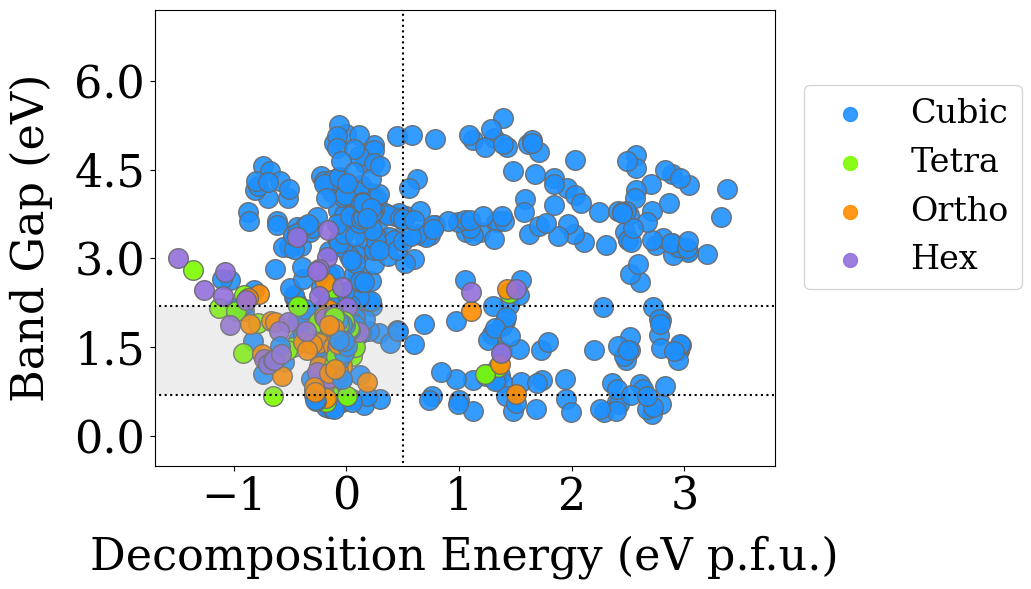

In [4]:
###   Visualize DFT Data, Decomp vs Gap    ###

n = len(df.Index[:])

fig = plt.figure( figsize=(10,6) )
plt.subplots_adjust(left=0.14, bottom=0.20, right=0.76, top=0.96)
plt.rc('font', family='serif')

for i in range(0,n):

    if df.Cubic[i] == 1:
        if Data == 'PBE' or Data == 'HSE':
                plt.scatter(df.Decomp[i], df.Gap[i], c='dodgerblue', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
        if Data == 'PBE_HSE_Expt' or Data == 'PBE_and_HSE':
            if df.PBE[i] == 1:
                plt.scatter(df.Decomp[i], df.Gap[i], c='dodgerblue', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
            if df.HSE[i] == 1:
                plt.scatter(df.Decomp[i], df.Gap[i], c='dodgerblue', marker='s', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')

    if df.Tetra[i] == 1:
        if Data == 'PBE' or Data == 'HSE':
                plt.scatter(df.Decomp[i], df.Gap[i], c='lawngreen', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
        if Data == 'PBE_HSE_Expt' or Data == 'PBE_and_HSE':
            if df.PBE[i] == 1:
                plt.scatter(df.Decomp[i], df.Gap[i], c='lawngreen', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
            if df.HSE[i] == 1:
                plt.scatter(df.Decomp[i], df.Gap[i], c='lawngreen', marker='s', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')

    if df.Ortho[i] == 1:
        if Data == 'PBE' or Data == 'HSE':
                plt.scatter(df.Decomp[i], df.Gap[i], c='darkorange', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
        if Data == 'PBE_HSE_Expt' or Data == 'PBE_and_HSE':
            if df.PBE[i] == 1:
                plt.scatter(df.Decomp[i], df.Gap[i], c='darkorange', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
            if df.HSE[i] == 1:
                plt.scatter(df.Decomp[i], df.Gap[i], c='darkorange', marker='s', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')

    if df.Hex[i] == 1:
        if Data == 'PBE' or Data == 'HSE':
                plt.scatter(df.Decomp[i], df.Gap[i], c='mediumpurple', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
        if Data == 'PBE_HSE_Expt' or Data == 'PBE_and_HSE':
            if df.PBE[i] == 1:
                plt.scatter(df.Decomp[i], df.Gap[i], c='mediumpurple', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
            if df.HSE[i] == 1:
                plt.scatter(df.Decomp[i], df.Gap[i], c='mediumpurple', marker='s', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')

plt.scatter(1000, 1000, c='dodgerblue', marker='o', s=100, edgecolors='dodgerblue', alpha=0.9, label='Cubic')
plt.scatter(1000, 1000, c='lawngreen', marker='o', s=100, edgecolors='lawngreen', alpha=0.9, label='Tetra')
plt.scatter(1000, 1000, c='darkorange', marker='o', s=100, edgecolors='darkorange', alpha=0.9, label='Ortho')
plt.scatter(1000, 1000, c='mediumpurple', marker='o', s=100, edgecolors='mediumpurple', alpha=0.9, label='Hex')
if Data == 'PBE_HSE_Expt' or Data == 'PBE_and_HSE':
    plt.scatter(1000, 1000, c='dimgrey', marker='o', s=100, edgecolors='dimgrey', alpha=0.9, label='PBE')
    plt.scatter(1000, 1000, c='dimgrey', marker='s', s=100, edgecolors='dimgrey', alpha=0.9, label='HSE')


a = [0.7,0.7,0.7]
b = [-1000,0,1000]
c = [0.5,0.5,0.5]
d = [2.2,2.2,2.2]
plt.plot(b, a, c='k', ls=':')
plt.plot(b, d, c='k', ls=':')
plt.plot(c, b, c='k', ls=':')
x1 = np.arange(-1000, c[0],  0.01)

plt.fill_between(x1, a[0], d[0], facecolor='darkgrey', alpha=0.2)

plt.xlim([-1.7, 3.8])
plt.ylim([-0.5, 7.2])
plt.xticks([-1.0, 0.0, 1.0, 2.0, 3.0], fontsize=32)
plt.yticks([0.0, 1.5, 3.0, 4.5, 6.0], fontsize=32)
plt.xlabel('Decomposition Energy (eV p.f.u.)', fontsize=32, labelpad=12)
plt.ylabel('Band Gap (eV)', fontsize=32, labelpad=15)
plt.legend(bbox_to_anchor=(1.02,0.35), ncol=1, frameon=True, prop={'family':'serif','size':24})
#plt.savefig('plot_decomp_gap.pdf', dpi=450)



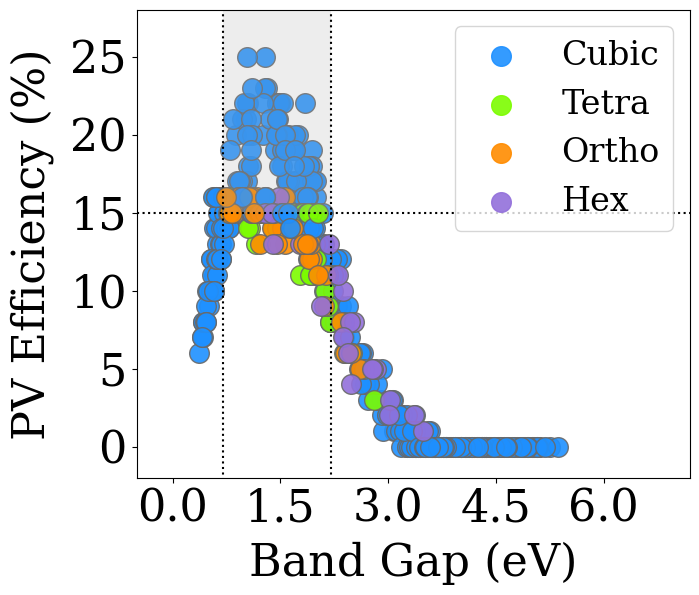

In [5]:
###   Visualize DFT Data, Gap vs SLME    ###

n = len(df.Index[:])

fig = plt.figure( figsize=(7,6) )
plt.subplots_adjust(left=0.18, bottom=0.18, right=0.97, top=0.96)
plt.rc('font', family='serif')

for i in range(0,n):

    if Data == 'PBE_HSE_Expt':
        if df.Expt[i] == 1:
            plt.scatter(df.Gap[i], df.SLME[i]*100, c='dimgrey', marker='*', s=300, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')

    if df.Cubic[i] == 1:
        if Data == 'PBE' or Data == 'HSE':
            plt.scatter(df.Gap[i], df.SLME[i]*100, c='dodgerblue', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
        if Data == 'PBE_HSE_Expt' or Data == 'PBE_and_HSE':
            if df.PBE[i] == 1:
                plt.scatter(df.Gap[i], df.SLME[i]*100, c='dodgerblue', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
            if df.HSE[i] == 1:
                plt.scatter(df.Gap[i], df.SLME[i]*100, c='dodgerblue', marker='s', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')

    if df.Tetra[i] == 1:
        if Data == 'PBE' or Data == 'HSE':
            plt.scatter(df.Gap[i], df.SLME[i]*100, c='lawngreen', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
        if Data == 'PBE_HSE_Expt' or Data == 'PBE_and_HSE':
            if df.PBE[i] == 1:
                plt.scatter(df.Gap[i], df.SLME[i]*100, c='lawngreen', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
            if df.HSE[i] == 1:
                plt.scatter(df.Gap[i], df.SLME[i]*100, c='lawngreen', marker='s', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')

    if df.Ortho[i] == 1:
        if Data == 'PBE' or Data == 'HSE':
            plt.scatter(df.Gap[i], df.SLME[i]*100, c='darkorange', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
        if Data == 'PBE_HSE_Expt' or Data == 'PBE_and_HSE':
            if df.PBE[i] == 1:
                plt.scatter(df.Gap[i], df.SLME[i]*100, c='darkorange', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
            if df.HSE[i] == 1:
                plt.scatter(df.Gap[i], df.SLME[i]*100, c='darkorange', marker='s', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')

    if df.Hex[i] == 1:
        if Data == 'PBE' or Data == 'HSE':
            plt.scatter(df.Gap[i], df.SLME[i]*100, c='mediumpurple', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
        if Data == 'PBE_HSE_Expt' or Data == 'PBE_and_HSE':
            if df.PBE[i] == 1:
                plt.scatter(df.Gap[i], df.SLME[i]*100, c='mediumpurple', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')
            if df.HSE[i] == 1:
                plt.scatter(df.Gap[i], df.SLME[i]*100, c='mediumpurple', marker='s', s=200, edgecolors='dimgrey', alpha=0.9, label='_nolabel_')

plt.scatter(1000, 1000, c='dodgerblue', marker='o', s=200, edgecolors='dodgerblue', alpha=0.9, label='Cubic')
plt.scatter(1000, 1000, c='lawngreen', marker='o', s=200, edgecolors='lawngreen', alpha=0.9, label='Tetra')
plt.scatter(1000, 1000, c='darkorange', marker='o', s=200, edgecolors='darkorange', alpha=0.9, label='Ortho')
plt.scatter(1000, 1000, c='mediumpurple', marker='o', s=200, edgecolors='mediumpurple', alpha=0.9, label='Hex')
if Data == 'PBE_and_HSE':
    plt.scatter(1000, 1000, c='dimgrey', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='PBE')
    plt.scatter(1000, 1000, c='dimgrey', marker='s', s=200, edgecolors='dimgrey', alpha=0.9, label='HSE')
if Data == 'PBE_HSE_Expt':
    plt.scatter(1000, 1000, c='dimgrey', marker='o', s=200, edgecolors='dimgrey', alpha=0.9, label='PBE')
    plt.scatter(1000, 1000, c='dimgrey', marker='s', s=200, edgecolors='dimgrey', alpha=0.9, label='HSE')
    plt.scatter(1000, 1000, c='dimgrey', marker='*', s=300, edgecolors='dimgrey', alpha=0.9, label='Expt.')


a = [0.7,0.7,0.7]
b = [-1000,0,1000]
c = [15,15,15]
d = [2.2,2.2,2.2]
plt.plot(a, b, c='k', ls=':')
plt.plot(d, b, c='k', ls=':')
plt.plot(b, c, c='k', ls=':')
x1 = np.arange(a[0], d[0],  0.01)

plt.fill_between(x1, c[0], 1000, facecolor='darkgrey', alpha=0.2)

plt.ylim([-2, 28])
plt.xlim([-0.5, 7.2])
plt.yticks([0, 5, 10, 15, 20, 25], fontsize=32)
plt.xticks([0.0, 1.5, 3.0, 4.5, 6.0], fontsize=32)
plt.ylabel('PV Efficiency (%)', fontsize=32, labelpad=12)
plt.xlabel('Band Gap (eV)', fontsize=32, labelpad=8)
plt.legend(loc='upper right', ncol=1, frameon=True, prop={'family':'serif','size':24})
#plt.savefig('plot_gap_slme.pdf', dpi=450)



In [6]:
##  Function to generate elemental property descriptors, used for GA or any new compound  ##

def desc(Comp):

    !wget https://raw.githubusercontent.com/mannodiarun/mrs_spring_tutorial/perovs_dft_ml/Elem_prop.xlsx
    Data = pd.read_excel('Elem_prop.xlsx')

    Elem_desc = [0.0]*36
    for i in range(0,12):
        Elem_desc[i] = Data.K[i]*Comp[0] + Data.Rb[i]*Comp[1] + Data.Cs[i]*Comp[2] + Data.MA[i]*Comp[3] + Data.FA[i]*Comp[4]
        Elem_desc[i+12] = Data.Ca[i]*Comp[5] + Data.Sr[i]*Comp[6] + Data.Ba[i]*Comp[7] + Data.Ge[i]*Comp[8] + Data.Sn[i]*Comp[9] + Data.Pb[i]*Comp[10]
        Elem_desc[i+24] = Data.Cl[i]*Comp[11] + Data.Br[i]*Comp[12] + Data.I[i]*Comp[13]

    return(Elem_desc)



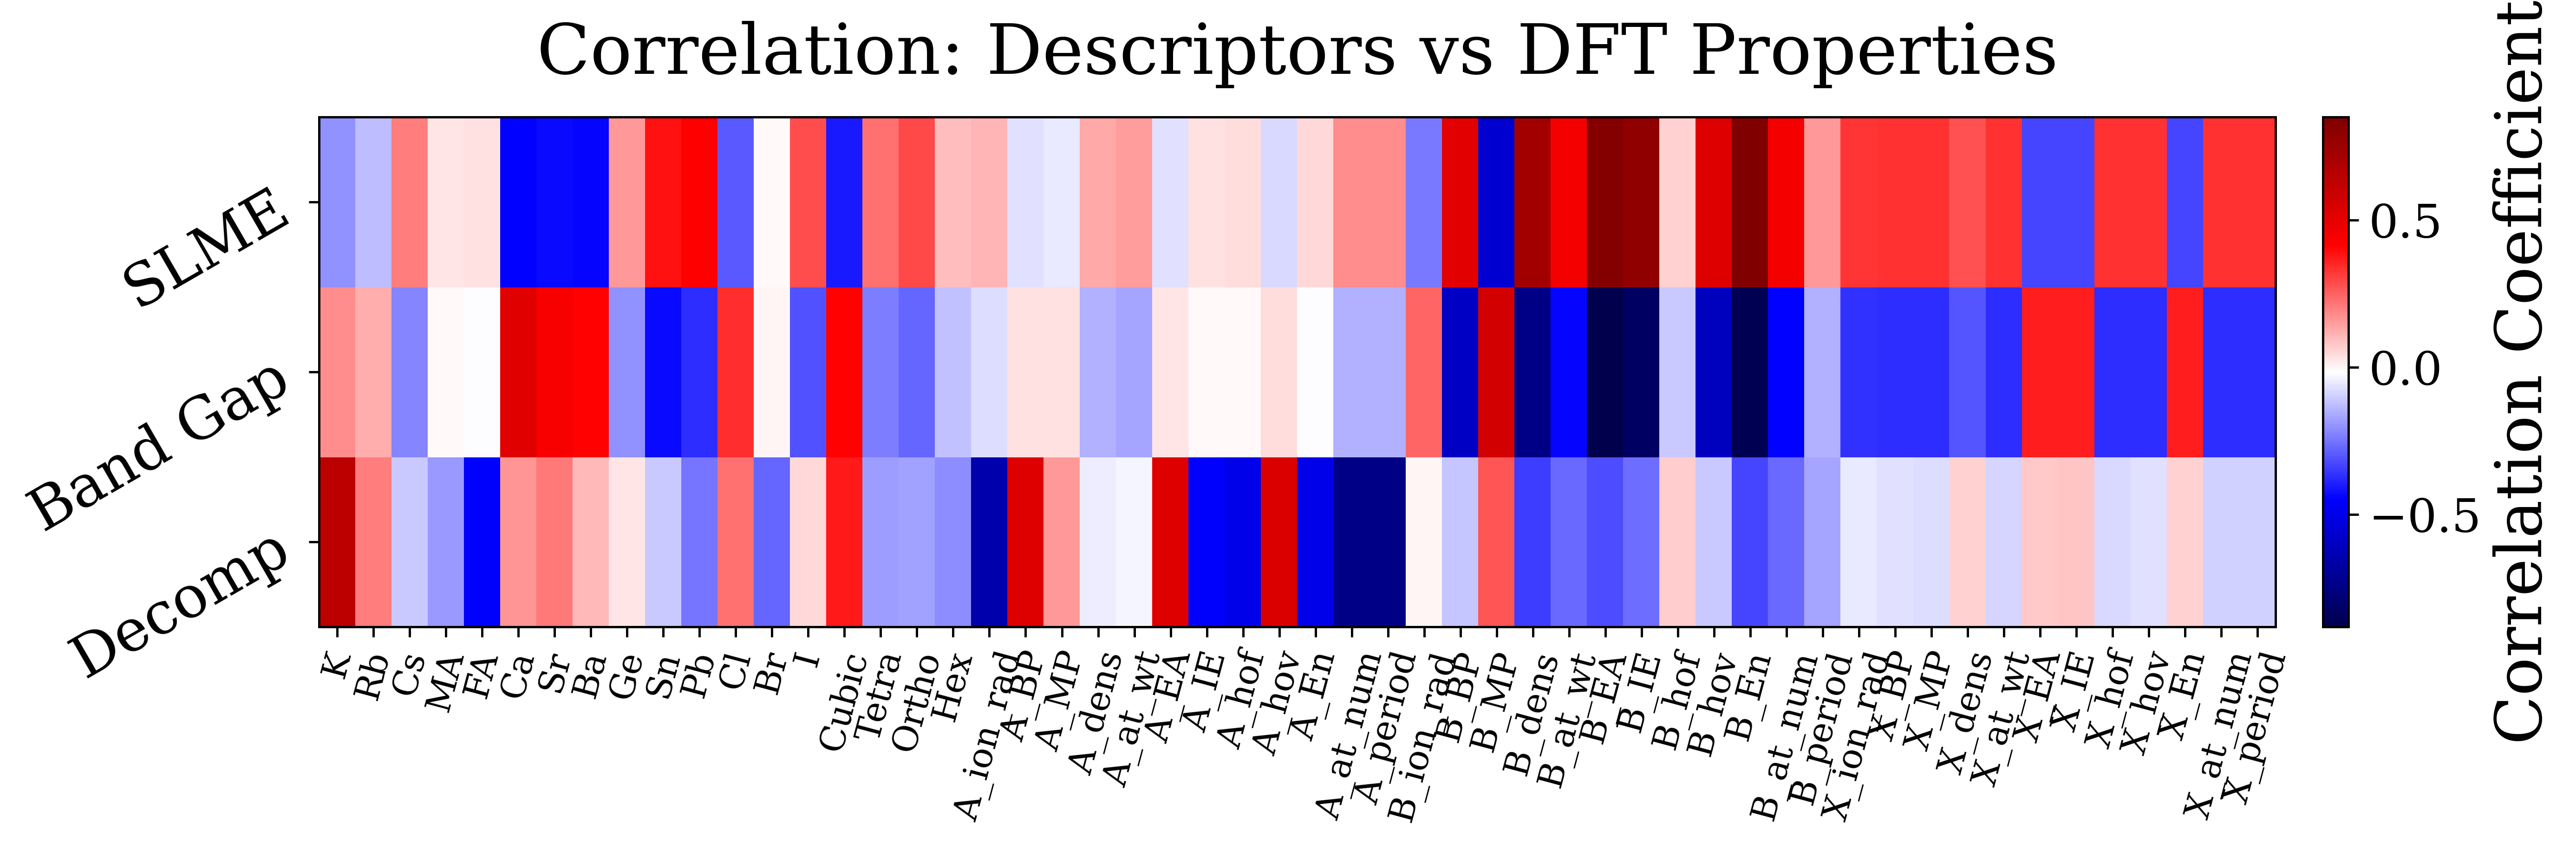

In [28]:
###   Pearson Coefficient of Linear Correlation    ###


##  Run this cell only for DFT data (Data = PBE, HSE, or PBE+HSE)  ##

Corr = [[0.0 for a in range(dim)] for b in range(3)]

for i in range(0,dim):
    x = stats.pearsonr(X_fl[:,i], Decomp[:])
    Corr[0][i] = x[0]
    x = stats.pearsonr(X_fl[:,i], Gap[:])
    Corr[1][i] = x[0]
    x = stats.pearsonr(X_fl[:,i], SLME[:])
    Corr[2][i] = x[0]

## Save the Corr matrix if you want to look at the actual values ##
#np.savetxt('Corr.csv', Corr)


x = np.arange(dim)
xx = [0.0]*dim
for i in range(0,dim):
    xx[i] = x[i]+0.5
y = [0.5,1.5,2.5]
f = 16
r = 75
Prop = ['Decomp', 'Band Gap', 'SLME']


scale = ['linear']
plotposition = [131, 132, 133]

fig=plt.figure(figsize=(12,4),dpi=450)
plt.rcParams.update({'font.size': 16})
plt.rc('font', family='serif')
plt.subplots_adjust(left=0.10, right=1.04, top=0.85, bottom=0.24, wspace=0.2, hspace=0.2)

ax = plt.plot(plotposition[0])
plt.plot(plotposition[0])
plt.xscale(scale[0])
plt.yscale(scale[0])
plt.xlim([0,dim])
plt.ylim([0,3])

if Data == 'PBE' or Data == 'HSE':
    if Desc == 'Composition Only':
        Labels = ['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex']
    if Desc == 'Elemental Only':
        Labels = ['Cubic', 'Tetra', 'Ortho', 'Hex', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period']
    if Desc == 'Composition and Elemental':
        Labels = ['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period']

if Data == 'PBE_and_HSE':
    if Desc == 'Composition Only':
        Labels = ['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE']
    if Desc == 'Elemental Only':
        Labels = ['Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period']
    if Desc == 'Composition and Elemental':
        Labels = ['K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens', 'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad', 'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num', 'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof', 'X_hov', 'X_En', 'X_at_num', 'X_period']

plt.xticks(xx[0:dim], Labels[0:dim], rotation=75, fontsize=12)
plt.yticks(y[:], Prop[:], rotation=30, fontsize=20)
plt.title('Correlation: Descriptors vs DFT Properties', fontname='serif', size=24, horizontalalignment='center', pad=15)
plt.pcolor(Corr, cmap='seismic')
cbar = plt.colorbar(orientation="vertical", pad=0.02)
cbar.set_label(label='Correlation Coefficient', size=22)
#plt.savefig('corr.pdf', dpi=450)



In [35]:
np.sort(np.abs(Corr[0]))

array([0.00330778, 0.02701323, 0.0319888 , 0.04942537, 0.05114245,
       0.05624227, 0.06138946, 0.06295637, 0.06780257, 0.06922028,
       0.0698064 , 0.07334159, 0.07517649, 0.07942478, 0.07952724,
       0.08842661, 0.09305717, 0.09306351, 0.10343076, 0.1043638 ,
       0.10959418, 0.11013634, 0.11426776, 0.15884826, 0.16192644,
       0.17014032, 0.17489688, 0.18430721, 0.18997274, 0.20215649,
       0.21101757, 0.21417616, 0.22352872, 0.25158489, 0.26292962,
       0.27017501, 0.27166436, 0.27219946, 0.27310687, 0.31487098,
       0.33270511, 0.3411563 , 0.37000549, 0.44915524, 0.45197065,
       0.49755457, 0.49983117, 0.52791783, 0.52934452, 0.54506836,
       0.64651157, 0.6516083 , 0.7387147 , 0.73871994])

In [36]:
np.argsort(np.abs(Corr[0]))

array([30,  8, 22, 21, 13, 42, 51, 45, 50, 43, 37, 44, 47, 48, 49, 46, 53,
       52,  7,  2, 38,  9, 31, 20,  5, 41, 16, 15,  3,  1, 17,  6, 11, 10,
       36, 32, 34, 40, 12, 35, 39, 33, 14, 24,  4, 25, 27, 23, 19, 26,  0,
       18, 29, 28])

In [37]:
Labels[28], Labels[29], Labels[18], Labels[0], Labels[26]

('A_at_num', 'A_period', 'A_ion_rad', 'K', 'A_hov')

In [17]:
Corr[0]

[0.626395101391278,
 0.2032407141535474,
 0.001822926246865992,
 -0.29303082623951016,
 -0.4402763592344552,
 0.1347986079416712,
 0.06521861281287283,
 0.1464092660126624,
 -0.014768179410495293,
 -0.1431091703789614,
 -0.13617977699844935,
 0.17846961904148392,
 -0.3028973668746662,
 0.11540761334976421,
 0.3079246500874641,
 -0.1653684742184458,
 -0.15426919957026958,
 -0.1809378808640698,
 -0.688033477580455,
 0.6154432706088895,
 0.2406481710249058,
 0.0662539736865724,
 0.08194852171723871,
 0.6112520170537245,
 -0.5473501345269158,
 -0.5829369875702101,
 0.6295865453726139,
 -0.5871115309083761,
 -0.7530841443780296,
 -0.7530967240215107,
 0.04869449871826506,
 -0.13058335758693818,
 0.20146406651743556,
 -0.2223661649923784,
 -0.1447689245268999,
 -0.22040247152850578,
 -0.21749985205057387,
 0.014232682137111598,
 -0.14304509173530783,
 -0.2400496865584459,
 -0.1462820018934586,
 -0.05896228911549446,
 0.008561247250526377,
 -0.005155445798766701,
 -0.009257244954968241,
 0.12

In [18]:
np.abs(Corr[0])

array([0.6263951 , 0.20324071, 0.00182293, 0.29303083, 0.44027636,
       0.13479861, 0.06521861, 0.14640927, 0.01476818, 0.14310917,
       0.13617978, 0.17846962, 0.30289737, 0.11540761, 0.30792465,
       0.16536847, 0.1542692 , 0.18093788, 0.68803348, 0.61544327,
       0.24064817, 0.06625397, 0.08194852, 0.61125202, 0.54735013,
       0.58293699, 0.62958655, 0.58711153, 0.75308414, 0.75309672,
       0.0486945 , 0.13058336, 0.20146407, 0.22236616, 0.14476892,
       0.22040247, 0.21749985, 0.01423268, 0.14304509, 0.24004969,
       0.146282  , 0.05896229, 0.00856125, 0.00515545, 0.00925724,
       0.12691453, 0.02543377, 0.011573  , 0.01627337, 0.0158353 ,
       0.0035712 , 0.00284326, 0.0300855 , 0.03003529])

In [ ]:
###  Function: Training-Test Split  ###
###  Run this cell for PBE-sf, HSE-sf, PBE-HSE-mf1 models  ###

def split_1():
    t = 0.20
    X_train, X_test, Prop_decomp_train, Prop_decomp_test, Prop_gap_train, Prop_gap_test, Prop_slme_train, Prop_slme_test, Index_train, Index_test, Formulas_train, Formulas_test = train_test_split(X, Decomp, Gap, SLME, Index, Formula, test_size=t)
    n_tr = Prop_gap_train.size
    n_te = Prop_gap_test.size

    X_train_fl = np.array(X_train, dtype="float32")
    Prop_decomp_train_fl = np.array(Prop_decomp_train, dtype="float32")
    Prop_gap_train_fl = np.array(Prop_gap_train, dtype="float32")
    Prop_slme_train_fl = np.array(Prop_slme_train, dtype="float32")
    Index_train_fl = np.array(Index_train, dtype="float32")

    X_test_fl = np.array(X_test, dtype="float32")
    Prop_decomp_test_fl = np.array(Prop_decomp_test, dtype="float32")
    Prop_gap_test_fl = np.array(Prop_gap_test, dtype="float32")
    Prop_slme_test_fl = np.array(Prop_slme_test, dtype="float32")
    Index_test_fl = np.array(Index_test, dtype="float32")

    return (X_train_fl, X_test_fl, Prop_decomp_train_fl, Prop_decomp_test_fl, Prop_gap_train_fl, Prop_gap_test_fl, Prop_slme_train_fl, Prop_slme_test_fl, Index_train_fl, Index_test_fl, Formulas_train, Formulas_test)


In [ ]:
###  Function: Training-Test Split  ###
###  Run this cell for PBE-HSE-Expt mf2 model + GA  ###

def split_2():
    t = 0.20
    X_train_1, X_test_1, Prop_gap_train, Prop_gap_test, Index_train_1, Index_test_1 = train_test_split(X, Gap, Index, test_size=t)
    X_train_2, X_test_2, Prop_slme_train, Prop_slme_test, Index_train_2, Index_test_2 = train_test_split(X_2, SLME, Index_2, test_size=t)
    n_tr = Prop_gap_train.size
    n_te = Prop_gap_test.size

    X_train_fl_1 = np.array(X_train_1, dtype="float32")
    X_train_fl_2 = np.array(X_train_2, dtype="float32")
    Prop_gap_train_fl = np.array(Prop_gap_train, dtype="float32")
    Prop_slme_train_fl = np.array(Prop_slme_train, dtype="float32")
    Index_train_fl_1 = np.array(Index_train_1, dtype="float32")
    Index_train_fl_2 = np.array(Index_train_2, dtype="float32")

    X_test_fl_1 = np.array(X_test_1, dtype="float32")
    X_test_fl_2 = np.array(X_test_2, dtype="float32")
    Prop_gap_test_fl = np.array(Prop_gap_test, dtype="float32")
    Prop_slme_test_fl = np.array(Prop_slme_test, dtype="float32")
    Index_test_fl_1 = np.array(Index_test_1, dtype="float32")
    Index_test_fl_2 = np.array(Index_test_2, dtype="float32")

    return (X_train_fl_1, X_test_fl_1, X_train_fl_2, X_test_fl_2, Prop_gap_train_fl, Prop_gap_test_fl, Prop_slme_train_fl, Prop_slme_test_fl, Index_train_fl_1, Index_test_fl_1, Index_train_fl_2, Index_test_fl_2)


In [ ]:
###  Function: Define Hyperparameters + Train Random Forest Regression Models  ###
###  Run this cell for PBE-sf, HSE-sf, PBE-HSE-mf1 models  ###


def RFR_1(X_train_fl, X_test_fl, Prop_decomp_train_fl, Prop_decomp_test_fl, Prop_gap_train_fl, Prop_gap_test_fl, Prop_slme_train_fl, Prop_slme_test_fl):
#    param_grid = {"n_estimators": [50, 100, 200],
#        "max_features": [10, 20, 40, m],
#        "min_samples_leaf": [5,10,20],
#        "max_depth": [5,10,15],
#        "min_samples_split": [2, 5, 10, 15]
#                 }
    param_grid = {}

#  Train Model For Decomposition Energy ##
    rfr_decomp = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv=5)
    rfr_decomp.fit(X_train_fl, Prop_decomp_train_fl)
    Pred_train = rfr_decomp.predict(X_train_fl)
    Pred_test = rfr_decomp.predict(X_test_fl)
    Pred_expt = rfr_decomp.predict(X_expt_fl)
    Pred_out = rfr_decomp.predict(X_out_fl)
    Pred_all = rfr_decomp.predict(X_fl)
    Pred_decomp_train_fl = np.array(Pred_train, dtype="float32")
    Pred_decomp_test_fl = np.array(Pred_test, dtype="float32")
    Pred_decomp_expt_fl = np.array(Pred_expt, dtype="float32")
    Pred_decomp_out_fl = np.array(Pred_out, dtype="float32")
    Pred_decomp_all_fl = np.array(Pred_all, dtype="float32")
    rmse_test_decomp = np.sqrt( sklearn.metrics.mean_squared_error(Prop_decomp_test_fl, Pred_decomp_test_fl) )
    rmse_train_decomp = np.sqrt( sklearn.metrics.mean_squared_error(Prop_decomp_train_fl, Pred_decomp_train_fl) )

#  Train Model For Band Gap ##
    rfr_gap = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv=5)
    rfr_gap.fit(X_train_fl, Prop_gap_train_fl)
    Pred_train = rfr_gap.predict(X_train_fl)
    Pred_test = rfr_gap.predict(X_test_fl)
    Pred_expt = rfr_gap.predict(X_expt_fl)
    Pred_out = rfr_gap.predict(X_out_fl)
    Pred_all = rfr_gap.predict(X_fl)
    Pred_gap_train_fl = np.array(Pred_train, dtype="float32")
    Pred_gap_test_fl = np.array(Pred_test, dtype="float32")
    Pred_gap_expt_fl = np.array(Pred_expt, dtype="float32")
    Pred_gap_out_fl = np.array(Pred_out, dtype="float32")
    Pred_gap_all_fl = np.array(Pred_all, dtype="float32")
    rmse_test_gap = np.sqrt( sklearn.metrics.mean_squared_error(Prop_gap_test_fl, Pred_gap_test_fl) )
    rmse_train_gap = np.sqrt( sklearn.metrics.mean_squared_error(Prop_gap_train_fl, Pred_gap_train_fl) )

#  Train Model For PV SLME ##
    rfr_slme = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv=5)
    rfr_slme.fit(X_train_fl, Prop_slme_train_fl)
    Pred_train = rfr_slme.predict(X_train_fl)
    Pred_test = rfr_slme.predict(X_test_fl)
    Pred_expt = rfr_slme.predict(X_expt_fl)
    Pred_out = rfr_slme.predict(X_out_fl)
    Pred_all = rfr_slme.predict(X_fl)
    Pred_slme_train_fl = np.array(Pred_train, dtype="float32")
    Pred_slme_test_fl = np.array(Pred_test, dtype="float32")
    Pred_slme_expt_fl = np.array(Pred_expt, dtype="float32")
    Pred_slme_out_fl = np.array(Pred_out, dtype="float32")
    Pred_slme_all_fl = np.array(Pred_all, dtype="float32")
    rmse_test_slme = np.sqrt( sklearn.metrics.mean_squared_error(Prop_slme_test_fl, Pred_slme_test_fl) )
    rmse_train_slme = np.sqrt( sklearn.metrics.mean_squared_error(Prop_slme_train_fl, Pred_slme_train_fl) )


    return (Pred_decomp_train_fl, Pred_decomp_test_fl, Pred_decomp_expt_fl, Pred_decomp_out_fl, Pred_decomp_all_fl, rmse_test_decomp, rmse_train_decomp, Pred_gap_train_fl, Pred_gap_test_fl, Pred_gap_expt_fl, Pred_gap_out_fl, Pred_gap_all_fl, rmse_test_gap, rmse_train_gap, Pred_slme_train_fl, Pred_slme_test_fl, Pred_slme_expt_fl, Pred_slme_out_fl, Pred_slme_all_fl, rmse_test_slme, rmse_train_slme, rfr_decomp, rfr_gap, rfr_slme)



In [ ]:
###  Function: Define Hyperparameters + Train Random Forest Regression Models  ###
###  Run this cell for PBE-HSE-Expt mf2 model  ###

def RFR_2(X_train_fl_1, X_test_fl_1, X_train_fl_2, X_test_fl_2, Prop_gap_train_fl, Prop_gap_test_fl, Prop_slme_train_fl, Prop_slme_test_fl, Index_train_fl_1, Index_test_fl_1, Index_train_fl_2, Index_test_fl_2):
#    param_grid = {"n_estimators": [50, 100, 200],
#        "max_features": [int(m/3), int(m/2), m],
#        "min_samples_leaf": [5,10,20],
#        "max_depth": [5,10,15],
#        "min_samples_split": [5, 10, 15]
#                 }
    param_grid = {}

#  Train Model For Band Gap ##
    rfr_gap = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv=5)
    rfr_gap.fit(X_train_fl_1, Prop_gap_train_fl)
    Pred_train = rfr_gap.predict(X_train_fl_1)
    Pred_test = rfr_gap.predict(X_test_fl_1)
    Pred_expt = rfr_gap.predict(X_expt_fl)
    Pred_out = rfr_gap.predict(X_out_fl)
    Pred_all = rfr_gap.predict(X_fl_1)
    Pred_gap_train_fl = np.array(Pred_train, dtype="float32")
    Pred_gap_test_fl = np.array(Pred_test, dtype="float32")
    Pred_gap_expt_fl = np.array(Pred_expt, dtype="float32")
    Pred_gap_out_fl = np.array(Pred_out, dtype="float32")
    Pred_gap_all_fl = np.array(Pred_all, dtype="float32")
    rmse_test_gap = np.sqrt( sklearn.metrics.mean_squared_error(Prop_gap_test_fl, Pred_gap_test_fl) )
    rmse_train_gap = np.sqrt( sklearn.metrics.mean_squared_error(Prop_gap_train_fl, Pred_gap_train_fl) )

#  Train Model For PV SLME ##
    rfr_slme = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, cv=5)
    rfr_slme.fit(X_train_fl_2, Prop_slme_train_fl)
    Pred_train = rfr_slme.predict(X_train_fl_2)
    Pred_test = rfr_slme.predict(X_test_fl_2)
    Pred_expt = rfr_slme.predict(X_expt_fl)
    Pred_out = rfr_slme.predict(X_out_fl)
    Pred_all = rfr_slme.predict(X_fl_2)
    Pred_slme_train_fl = np.array(Pred_train, dtype="float32")
    Pred_slme_test_fl = np.array(Pred_test, dtype="float32")
    Pred_slme_expt_fl = np.array(Pred_expt, dtype="float32")
    Pred_slme_out_fl = np.array(Pred_out, dtype="float32")
    Pred_slme_all_fl = np.array(Pred_all, dtype="float32")
    rmse_test_slme = np.sqrt( sklearn.metrics.mean_squared_error(Prop_slme_test_fl, Pred_slme_test_fl) )
    rmse_train_slme = np.sqrt( sklearn.metrics.mean_squared_error(Prop_slme_train_fl, Pred_slme_train_fl) )


    return (Pred_gap_train_fl, Pred_gap_test_fl, Pred_gap_expt_fl, Pred_gap_out_fl, Pred_gap_all_fl, rmse_test_gap, rmse_train_gap, Pred_slme_train_fl, Pred_slme_test_fl, Pred_slme_expt_fl, Pred_slme_out_fl, Pred_slme_all_fl, rmse_test_slme, rmse_train_slme, rfr_gap, rfr_slme)



In [ ]:
###  Function: Define Hyperparameters + Train Elastic Net Regression Models  ###
###  Run this cell for PBE-sf, HSE-sf, PBE-HSE-mf1 models  ###


def ENET_1(X_train_fl, X_test_fl, Prop_decomp_train_fl, Prop_decomp_test_fl, Prop_gap_train_fl, Prop_gap_test_fl, Prop_slme_train_fl, Prop_slme_test_fl):
    param_grid = {"alpha": [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
                  "max_iter": [1e3, 1e4],
                  #"tol": [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
                  "tol": [1e-1]}
    param_grid = {}

#  Train Model For Decomposition Energy ##
    enet_decomp = GridSearchCV(ElasticNet(), param_grid=param_grid, cv=5)
    enet_decomp.fit(X_train_fl, Prop_decomp_train_fl)
    Pred_train = enet_decomp.predict(X_train_fl)
    Pred_test = enet_decomp.predict(X_test_fl)
    Pred_expt = enet_decomp.predict(X_expt_fl)
    Pred_out = enet_decomp.predict(X_out_fl)
    Pred_all = enet_decomp.predict(X_fl)
    Pred_decomp_train_fl = np.array(Pred_train, dtype="float32")
    Pred_decomp_test_fl = np.array(Pred_test, dtype="float32")
    Pred_decomp_expt_fl = np.array(Pred_expt, dtype="float32")
    Pred_decomp_out_fl = np.array(Pred_out, dtype="float32")
    Pred_decomp_all_fl = np.array(Pred_all, dtype="float32")
    rmse_test_decomp = np.sqrt( sklearn.metrics.mean_squared_error(Prop_decomp_test_fl, Pred_decomp_test_fl) )
    rmse_train_decomp = np.sqrt( sklearn.metrics.mean_squared_error(Prop_decomp_train_fl, Pred_decomp_train_fl) )

#  Train Model For Band Gap ##
    enet_gap = GridSearchCV(ElasticNet(), param_grid=param_grid, cv=5)
    enet_gap.fit(X_train_fl, Prop_gap_train_fl)
    Pred_train = enet_gap.predict(X_train_fl)
    Pred_test = enet_gap.predict(X_test_fl)
    Pred_expt = enet_gap.predict(X_expt_fl)
    Pred_out = enet_gap.predict(X_out_fl)
    Pred_all = enet_gap.predict(X_fl)
    Pred_gap_train_fl = np.array(Pred_train, dtype="float32")
    Pred_gap_test_fl = np.array(Pred_test, dtype="float32")
    Pred_gap_expt_fl = np.array(Pred_expt, dtype="float32")
    Pred_gap_out_fl = np.array(Pred_out, dtype="float32")
    Pred_gap_all_fl = np.array(Pred_all, dtype="float32")
    rmse_test_gap = np.sqrt( sklearn.metrics.mean_squared_error(Prop_gap_test_fl, Pred_gap_test_fl) )
    rmse_train_gap = np.sqrt( sklearn.metrics.mean_squared_error(Prop_gap_train_fl, Pred_gap_train_fl) )

#  Train Model For PV SLME ##
    enet_slme = GridSearchCV(ElasticNet(), param_grid=param_grid, cv=5)
    enet_slme.fit(X_train_fl, Prop_slme_train_fl)
    Pred_train = enet_slme.predict(X_train_fl)
    Pred_test = enet_slme.predict(X_test_fl)
    Pred_expt = enet_slme.predict(X_expt_fl)
    Pred_out = enet_slme.predict(X_out_fl)
    Pred_all = enet_slme.predict(X_fl)
    Pred_slme_train_fl = np.array(Pred_train, dtype="float32")
    Pred_slme_test_fl = np.array(Pred_test, dtype="float32")
    Pred_slme_expt_fl = np.array(Pred_expt, dtype="float32")
    Pred_slme_out_fl = np.array(Pred_out, dtype="float32")
    Pred_slme_all_fl = np.array(Pred_all, dtype="float32")
    rmse_test_slme = np.sqrt( sklearn.metrics.mean_squared_error(Prop_slme_test_fl, Pred_slme_test_fl) )
    rmse_train_slme = np.sqrt( sklearn.metrics.mean_squared_error(Prop_slme_train_fl, Pred_slme_train_fl) )


    return (Pred_decomp_train_fl, Pred_decomp_test_fl, Pred_decomp_expt_fl, Pred_decomp_out_fl, Pred_decomp_all_fl, rmse_test_decomp, rmse_train_decomp, Pred_gap_train_fl, Pred_gap_test_fl, Pred_gap_expt_fl, Pred_gap_out_fl, Pred_gap_all_fl, rmse_test_gap, rmse_train_gap, Pred_slme_train_fl, Pred_slme_test_fl, Pred_slme_expt_fl, Pred_slme_out_fl, Pred_slme_all_fl, rmse_test_slme, rmse_train_slme, enet_decomp, enet_gap, enet_slme)



In [ ]:
###  Function: Define Hyperparameters + Train Elastic Net Regression Models  ###
###  Run this cell for PBE-HSE-Expt mf2 model  ###

def ENET_2(X_train_fl_1, X_test_fl_1, X_train_fl_2, X_test_fl_2, Prop_gap_train_fl, Prop_gap_test_fl, Prop_slme_train_fl, Prop_slme_test_fl, Index_train_fl_1, Index_test_fl_1, Index_train_fl_2, Index_test_fl_2):
    param_grid = {"alpha": [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
                  "max_iter": [1e3, 1e4],
                  #"tol": [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
                  "tol": [1e-1]}
    param_grid = {}

#  Train Model For Band Gap ##
    enet_gap = GridSearchCV(ElasticNet(), param_grid=param_grid, cv=5)
    enet_gap.fit(X_train_fl_1, Prop_gap_train_fl)
    Pred_train = enet_gap.predict(X_train_fl_1)
    Pred_test = enet_gap.predict(X_test_fl_1)
    Pred_expt = enet_gap.predict(X_expt_fl)
    Pred_out = enet_gap.predict(X_out_fl)
    Pred_all = enet_gap.predict(X_fl_1)
    Pred_gap_train_fl = np.array(Pred_train, dtype="float32")
    Pred_gap_test_fl = np.array(Pred_test, dtype="float32")
    Pred_gap_expt_fl = np.array(Pred_expt, dtype="float32")
    Pred_gap_out_fl = np.array(Pred_out, dtype="float32")
    Pred_gap_all_fl = np.array(Pred_all, dtype="float32")
    rmse_test_gap = np.sqrt( sklearn.metrics.mean_squared_error(Prop_gap_test_fl, Pred_gap_test_fl) )
    rmse_train_gap = np.sqrt( sklearn.metrics.mean_squared_error(Prop_gap_train_fl, Pred_gap_train_fl) )

#  Train Model For PV SLME ##
    enet_slme = GridSearchCV(ElasticNet(), param_grid=param_grid, cv=5)
    enet_slme.fit(X_train_fl_2, Prop_slme_train_fl)
    Pred_train = enet_slme.predict(X_train_fl_2)
    Pred_test = enet_slme.predict(X_test_fl_2)
    Pred_expt = enet_slme.predict(X_expt_fl)
    Pred_out = enet_slme.predict(X_out_fl)
    Pred_all = enet_slme.predict(X_fl_2)
    Pred_slme_train_fl = np.array(Pred_train, dtype="float32")
    Pred_slme_test_fl = np.array(Pred_test, dtype="float32")
    Pred_slme_expt_fl = np.array(Pred_expt, dtype="float32")
    Pred_slme_out_fl = np.array(Pred_out, dtype="float32")
    Pred_slme_all_fl = np.array(Pred_all, dtype="float32")
    rmse_test_slme = np.sqrt( sklearn.metrics.mean_squared_error(Prop_slme_test_fl, Pred_slme_test_fl) )
    rmse_train_slme = np.sqrt( sklearn.metrics.mean_squared_error(Prop_slme_train_fl, Pred_slme_train_fl) )


    return (Pred_gap_train_fl, Pred_gap_test_fl, Pred_gap_expt_fl, Pred_gap_out_fl, Pred_gap_all_fl, rmse_test_gap, rmse_train_gap, Pred_slme_train_fl, Pred_slme_test_fl, Pred_slme_expt_fl, Pred_slme_out_fl, Pred_slme_all_fl, rmse_test_slme, rmse_train_slme, enet_gap, enet_slme)



In [ ]:
###  Function: Define Hyperparameters + Train Kernel Ridge Regression Models  ###
###  Run this cell for PBE-sf, HSE-sf, PBE-HSE-mf1 models  ###


def KRR_1(X_train_fl, X_test_fl, Prop_decomp_train_fl, Prop_decomp_test_fl, Prop_gap_train_fl, Prop_gap_test_fl, Prop_slme_train_fl, Prop_slme_test_fl):
    param_grid = {
        "alpha": [1e0, 1e-1, 1e-2, 1e-3],
        #"alpha": [10],
        "kernel": [ExpSineSquared(l, p)
            for l in np.logspace(-2, 2, 10)
            for p in np.logspace(0, 2, 10)]
    }
    param_grid = {}

#  Train Model For Decomposition Energy ##
    krr_decomp = GridSearchCV(KernelRidge(), param_grid=param_grid, cv=5)
    krr_decomp.fit(X_train_fl, Prop_decomp_train_fl)
    Pred_train = krr_decomp.predict(X_train_fl)
    Pred_test = krr_decomp.predict(X_test_fl)
    Pred_expt = krr_decomp.predict(X_expt_fl)
    Pred_out = krr_decomp.predict(X_out_fl)
    Pred_all = krr_decomp.predict(X_fl)
    Pred_decomp_train_fl = np.array(Pred_train, dtype="float32")
    Pred_decomp_test_fl = np.array(Pred_test, dtype="float32")
    Pred_decomp_expt_fl = np.array(Pred_expt, dtype="float32")
    Pred_decomp_out_fl = np.array(Pred_out, dtype="float32")
    Pred_decomp_all_fl = np.array(Pred_all, dtype="float32")
    rmse_test_decomp = np.sqrt( sklearn.metrics.mean_squared_error(Prop_decomp_test_fl, Pred_decomp_test_fl) )
    rmse_train_decomp = np.sqrt( sklearn.metrics.mean_squared_error(Prop_decomp_train_fl, Pred_decomp_train_fl) )

#  Train Model For Band Gap ##
    krr_gap = GridSearchCV(KernelRidge(), param_grid=param_grid, cv=5)
    krr_gap.fit(X_train_fl, Prop_gap_train_fl)
    Pred_train = krr_gap.predict(X_train_fl)
    Pred_test = krr_gap.predict(X_test_fl)
    Pred_expt = krr_gap.predict(X_expt_fl)
    Pred_out = krr_gap.predict(X_out_fl)
    Pred_all = krr_gap.predict(X_fl)
    Pred_gap_train_fl = np.array(Pred_train, dtype="float32")
    Pred_gap_test_fl = np.array(Pred_test, dtype="float32")
    Pred_gap_expt_fl = np.array(Pred_expt, dtype="float32")
    Pred_gap_out_fl = np.array(Pred_out, dtype="float32")
    Pred_gap_all_fl = np.array(Pred_all, dtype="float32")
    rmse_test_gap = np.sqrt( sklearn.metrics.mean_squared_error(Prop_gap_test_fl, Pred_gap_test_fl) )
    rmse_train_gap = np.sqrt( sklearn.metrics.mean_squared_error(Prop_gap_train_fl, Pred_gap_train_fl) )

#  Train Model For PV SLME ##
    krr_slme = GridSearchCV(KernelRidge(), param_grid=param_grid, cv=5)
    krr_slme.fit(X_train_fl, Prop_slme_train_fl)
    Pred_train = krr_slme.predict(X_train_fl)
    Pred_test = krr_slme.predict(X_test_fl)
    Pred_expt = krr_slme.predict(X_expt_fl)
    Pred_out = krr_slme.predict(X_out_fl)
    Pred_all = krr_slme.predict(X_fl)
    Pred_slme_train_fl = np.array(Pred_train, dtype="float32")
    Pred_slme_test_fl = np.array(Pred_test, dtype="float32")
    Pred_slme_expt_fl = np.array(Pred_expt, dtype="float32")
    Pred_slme_out_fl = np.array(Pred_out, dtype="float32")
    Pred_slme_all_fl = np.array(Pred_all, dtype="float32")
    rmse_test_slme = np.sqrt( sklearn.metrics.mean_squared_error(Prop_slme_test_fl, Pred_slme_test_fl) )
    rmse_train_slme = np.sqrt( sklearn.metrics.mean_squared_error(Prop_slme_train_fl, Pred_slme_train_fl) )


    return (Pred_decomp_train_fl, Pred_decomp_test_fl, Pred_decomp_expt_fl, Pred_decomp_out_fl, Pred_decomp_all_fl, rmse_test_decomp, rmse_train_decomp, Pred_gap_train_fl, Pred_gap_test_fl, Pred_gap_expt_fl, Pred_gap_out_fl, Pred_gap_all_fl, rmse_test_gap, rmse_train_gap, Pred_slme_train_fl, Pred_slme_test_fl, Pred_slme_expt_fl, Pred_slme_out_fl, Pred_slme_all_fl, rmse_test_slme, rmse_train_slme, krr_decomp, krr_gap, krr_slme)



In [ ]:
###  Function: Define Hyperparameters + Train Kernel Ridge Regression Models  ###
###  Run this cell for PBE-HSE-Expt mf2 model  ###

def KRR_2(X_train_fl_1, X_test_fl_1, X_train_fl_2, X_test_fl_2, Prop_gap_train_fl, Prop_gap_test_fl, Prop_slme_train_fl, Prop_slme_test_fl, Index_train_fl_1, Index_test_fl_1, Index_train_fl_2, Index_test_fl_2):
    param_grid = {
        #"alpha": [1e0, 1e-1, 1e-2, 1e-3],
        #"alpha": [10],
        "kernel": [ExpSineSquared(l, p)
            for l in np.logspace(-2, 2, 10)
            for p in np.logspace(0, 2, 10)]
    }
    param_grid = {}

#  Train Model For Band Gap ##
    krr_gap = GridSearchCV(KernelRidge(), param_grid=param_grid, cv=5)
    krr_gap.fit(X_train_fl_1, Prop_gap_train_fl)
    Pred_train = krr_gap.predict(X_train_fl_1)
    Pred_test = krr_gap.predict(X_test_fl_1)
    Pred_expt = krr_gap.predict(X_expt_fl)
    Pred_out = krr_gap.predict(X_out_fl)
    Pred_all = krr_gap.predict(X_fl_1)
    Pred_gap_train_fl = np.array(Pred_train, dtype="float32")
    Pred_gap_test_fl = np.array(Pred_test, dtype="float32")
    Pred_gap_expt_fl = np.array(Pred_expt, dtype="float32")
    Pred_gap_out_fl = np.array(Pred_out, dtype="float32")
    Pred_gap_all_fl = np.array(Pred_all, dtype="float32")
    rmse_test_gap = np.sqrt( sklearn.metrics.mean_squared_error(Prop_gap_test_fl, Pred_gap_test_fl) )
    rmse_train_gap = np.sqrt( sklearn.metrics.mean_squared_error(Prop_gap_train_fl, Pred_gap_train_fl) )

#  Train Model For PV SLME ##
    krr_slme = GridSearchCV(KernelRidge(), param_grid=param_grid, cv=5)
    krr_slme.fit(X_train_fl_2, Prop_slme_train_fl)
    Pred_train = krr_slme.predict(X_train_fl_2)
    Pred_test = krr_slme.predict(X_test_fl_2)
    Pred_expt = krr_slme.predict(X_expt_fl)
    Pred_out = krr_slme.predict(X_out_fl)
    Pred_all = krr_slme.predict(X_fl_2)
    Pred_slme_train_fl = np.array(Pred_train, dtype="float32")
    Pred_slme_test_fl = np.array(Pred_test, dtype="float32")
    Pred_slme_expt_fl = np.array(Pred_expt, dtype="float32")
    Pred_slme_out_fl = np.array(Pred_out, dtype="float32")
    Pred_slme_all_fl = np.array(Pred_all, dtype="float32")
    rmse_test_slme = np.sqrt( sklearn.metrics.mean_squared_error(Prop_slme_test_fl, Pred_slme_test_fl) )
    rmse_train_slme = np.sqrt( sklearn.metrics.mean_squared_error(Prop_slme_train_fl, Pred_slme_train_fl) )


    return (Pred_gap_train_fl, Pred_gap_test_fl, Pred_gap_expt_fl, Pred_gap_out_fl, Pred_gap_all_fl, rmse_test_gap, rmse_train_gap, Pred_slme_train_fl, Pred_slme_test_fl, Pred_slme_expt_fl, Pred_slme_out_fl, Pred_slme_all_fl, rmse_test_slme, rmse_train_slme, krr_gap, krr_slme)



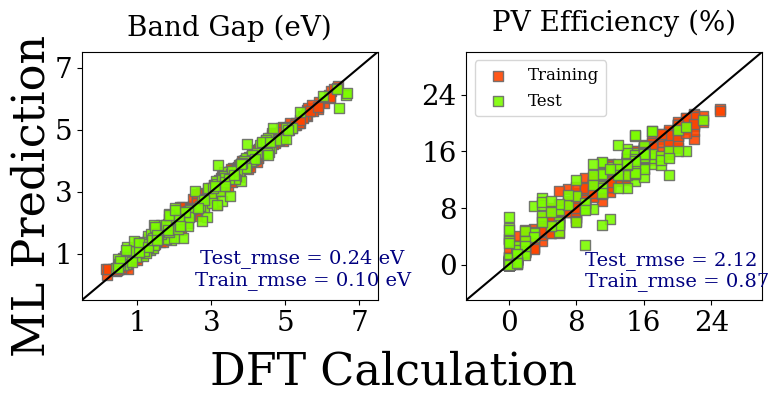

In [ ]:
###  Train RFR models on data, visualize using parity plots  ###


#reg = ENET_1
#reg = RFR_1
#reg = KRR_1
#reg = ENET_2
reg = RFR_2
#reg = KRR_2


if Data == 'PBE':

    X_train_fl, X_test_fl, Prop_decomp_train_fl, Prop_decomp_test_fl, Prop_gap_train_fl, Prop_gap_test_fl, Prop_slme_train_fl, Prop_slme_test_fl, Index_train_fl, Index_test_fl, Formulas_train, Formulas_test = split_1()
    Pred_decomp_train_fl, Pred_decomp_test_fl, Pred_decomp_expt_fl, Pred_decomp_out_fl, Pred_decomp_all_fl, rmse_test_decomp, rmse_train_decomp, Pred_gap_train_fl, Pred_gap_test_fl, Pred_gap_expt_fl, Pred_gap_out_fl, Pred_gap_all_fl, rmse_test_gap, rmse_train_gap, Pred_slme_train_fl, Pred_slme_test_fl, Pred_slme_expt_fl, Pred_slme_out_fl, Pred_slme_all_fl, rmse_test_slme, rmse_train_slme, reg_decomp, reg_gap, reg_slme = reg(X_train_fl, X_test_fl, Prop_decomp_train_fl, Prop_decomp_test_fl, Prop_gap_train_fl, Prop_gap_test_fl, Prop_slme_train_fl, Prop_slme_test_fl)

    fig, ( [ax1, ax2, ax3] ) = plt.subplots( nrows=1, ncols=3, figsize=(10,4) )
    fig.text(0.5, 0.03, 'DFT Calculation', ha='center', fontsize=32)
    fig.text(0.02, 0.5, 'ML Prediction', va='center', rotation='vertical', fontsize=32)
    plt.subplots_adjust(left=0.11, bottom=0.24, right=0.96, top=0.86, wspace=0.30, hspace=0.40)
    plt.rc('font', family='serif')
    a = [-175,0,125]
    b = [-175,0,125]

    Prop_train_temp = copy.deepcopy(Prop_decomp_train_fl)
    Pred_train_temp = copy.deepcopy(Pred_decomp_train_fl)
    Prop_test_temp  = copy.deepcopy(Prop_decomp_test_fl)
    Pred_test_temp  = copy.deepcopy(Pred_decomp_test_fl)
    ax1.plot(b, a, c='k', ls='-')
    ax1.xaxis.set_tick_params(labelsize=20)
    ax1.yaxis.set_tick_params(labelsize=20)
    ax1.scatter(Prop_train_temp[:], Pred_train_temp[:], c='orangered', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Training')
    ax1.scatter(Prop_test_temp[:], Pred_test_temp[:], c='lawngreen', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Test')
    te = '%.2f' % rmse_test_decomp
    tr = '%.2f' % rmse_train_decomp
    ax1.text(0.35, -0.80, 'Test_rmse = ' + te + ' eV', c='navy', fontsize=14)
    ax1.text(0.22, -1.35, 'Train_rmse = ' + tr + ' eV', c='navy', fontsize=14)
    ax1.set_ylim([-1.7, 3.8])
    ax1.set_xlim([-1.7, 3.8])
    ax1.set_xticks([-1.0, 0.0, 1.0, 2.0, 3.0])
    ax1.set_yticks([-1.0, 0.0, 1.0, 2.0, 3.0])
    ax1.set_title('Decomposition Energy (eV)', c='k', fontsize=20, pad=12)
    #ax1.legend(loc='upper left',ncol=1, frameon=True, prop={'family':'serif','size':12})

    Prop_train_temp = copy.deepcopy(Prop_gap_train_fl)
    Pred_train_temp = copy.deepcopy(Pred_gap_train_fl)
    Prop_test_temp  = copy.deepcopy(Prop_gap_test_fl)
    Pred_test_temp  = copy.deepcopy(Pred_gap_test_fl)
    ax2.plot(b, a, c='k', ls='-')
    ax2.xaxis.set_tick_params(labelsize=20)
    ax2.yaxis.set_tick_params(labelsize=20)
    ax2.scatter(Prop_train_temp[:], Pred_train_temp[:], c='orangered', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Training')
    ax2.scatter(Prop_test_temp[:], Pred_test_temp[:], c='lawngreen', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Test')
    te = '%.2f' % rmse_test_gap
    tr = '%.2f' % rmse_train_gap
    ax2.text(2.70, 0.7, 'Test_rmse = ' + te + ' eV', c='navy', fontsize=14)
    ax2.text(2.55, 0.0, 'Train_rmse = ' + tr + ' eV', c='navy', fontsize=14)
    ax2.set_ylim([-0.5, 7.5])
    ax2.set_xlim([-0.5, 7.5])
    ax2.set_xticks([1.0, 3.0, 5.0, 7.0])
    ax2.set_yticks([1.0, 3.0, 5.0, 7.0])
    ax2.set_title('Band Gap (eV)', c='k', fontsize=20, pad=12)
    #ax2.legend(loc='upper left',ncol=1, frameon=True, prop={'family':'serif','size':12})

    Prop_train_temp = copy.deepcopy(Prop_slme_train_fl*100)
    Pred_train_temp = copy.deepcopy(Pred_slme_train_fl*100)
    Prop_test_temp  = copy.deepcopy(Prop_slme_test_fl*100)
    Pred_test_temp  = copy.deepcopy(Pred_slme_test_fl*100)
    ax3.plot(b, a, c='k', ls='-')
    ax3.xaxis.set_tick_params(labelsize=20)
    ax3.yaxis.set_tick_params(labelsize=20)
    ax3.scatter(Prop_train_temp[:], Pred_train_temp[:], c='orangered', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Training')
    ax3.scatter(Prop_test_temp[:], Pred_test_temp[:], c='lawngreen', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Test')
    te = '%.2f' % (rmse_test_slme*100)
    tr = '%.2f' % (rmse_train_slme*100)
    ax3.text(6, 0, 'Test_rmse = ' + te, c='navy', fontsize=14)
    ax3.text(6, -2, 'Train_rmse = ' + tr, c='navy', fontsize=14)
    ax3.set_ylim([-3, 18])
    ax3.set_xlim([-3, 18])
    ax3.set_xticks([0, 5, 10, 15])
    ax3.set_yticks([0, 5, 10, 15])
    ax3.set_title('PV Efficiency (%)', fontsize=20, pad=15)
    ax3.legend(loc='upper left', ncol=1, frameon=True, prop={'family':'serif','size':12})
#    plt.savefig('plot_PBE_sf.pdf', dpi=450)



if Data == 'HSE':

    X_train_fl, X_test_fl, Prop_decomp_train_fl, Prop_decomp_test_fl, Prop_gap_train_fl, Prop_gap_test_fl, Prop_slme_train_fl, Prop_slme_test_fl, Index_train_fl, Index_test_fl, Formulas_train, Formulas_test = split_1()
    Pred_decomp_train_fl, Pred_decomp_test_fl, Pred_decomp_expt_fl, Pred_decomp_out_fl, Pred_decomp_all_fl, rmse_test_decomp, rmse_train_decomp, Pred_gap_train_fl, Pred_gap_test_fl, Pred_gap_expt_fl, Pred_gap_out_fl, Pred_gap_all_fl, rmse_test_gap, rmse_train_gap, Pred_slme_train_fl, Pred_slme_test_fl, Pred_slme_expt_fl, Pred_slme_out_fl, Pred_slme_all_fl, rmse_test_slme, rmse_train_slme, reg_decomp, reg_gap, reg_slme = reg(X_train_fl, X_test_fl, Prop_decomp_train_fl, Prop_decomp_test_fl, Prop_gap_train_fl, Prop_gap_test_fl, Prop_slme_train_fl, Prop_slme_test_fl)

    fig, ( [ax1, ax2, ax3] ) = plt.subplots( nrows=1, ncols=3, figsize=(10,4) )
    fig.text(0.5, 0.03, 'DFT Calculation', ha='center', fontsize=32)
    fig.text(0.02, 0.5, 'ML Prediction', va='center', rotation='vertical', fontsize=32)
    plt.subplots_adjust(left=0.11, bottom=0.24, right=0.96, top=0.86, wspace=0.30, hspace=0.40)
    plt.rc('font', family='serif')
    a = [-175,0,125]
    b = [-175,0,125]

    Prop_train_temp = copy.deepcopy(Prop_decomp_train_fl)
    Pred_train_temp = copy.deepcopy(Pred_decomp_train_fl)
    Prop_test_temp  = copy.deepcopy(Prop_decomp_test_fl)
    Pred_test_temp  = copy.deepcopy(Pred_decomp_test_fl)
    ax1.plot(b, a, c='k', ls='-')
    ax1.xaxis.set_tick_params(labelsize=20)
    ax1.yaxis.set_tick_params(labelsize=20)
    ax1.scatter(Prop_train_temp[:], Pred_train_temp[:], c='orangered', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Training')
    ax1.scatter(Prop_test_temp[:], Pred_test_temp[:], c='lawngreen', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Test')
    te = '%.2f' % rmse_test_decomp
    tr = '%.2f' % rmse_train_decomp
    ax1.text(0.35, -0.80, 'Test_rmse = ' + te + ' eV', c='navy', fontsize=14)
    ax1.text(0.22, -1.35, 'Train_rmse = ' + tr + ' eV', c='navy', fontsize=14)
    ax1.set_ylim([-1.7, 3.8])
    ax1.set_xlim([-1.7, 3.8])
    ax1.set_xticks([-1.0, 0.0, 1.0, 2.0, 3.0])
    ax1.set_yticks([-1.0, 0.0, 1.0, 2.0, 3.0])
    ax1.set_title('Decomposition Energy (eV)', c='k', fontsize=20, pad=12)
    #ax1.legend(loc='upper left',ncol=1, frameon=True, prop={'family':'serif','size':12})

    Prop_train_temp = copy.deepcopy(Prop_gap_train_fl)
    Pred_train_temp = copy.deepcopy(Pred_gap_train_fl)
    Prop_test_temp  = copy.deepcopy(Prop_gap_test_fl)
    Pred_test_temp  = copy.deepcopy(Pred_gap_test_fl)
    ax2.plot(b, a, c='k', ls='-')
    ax2.xaxis.set_tick_params(labelsize=20)
    ax2.yaxis.set_tick_params(labelsize=20)
    ax2.scatter(Prop_train_temp[:], Pred_train_temp[:], c='orangered', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Training')
    ax2.scatter(Prop_test_temp[:], Pred_test_temp[:], c='lawngreen', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Test')
    te = '%.2f' % rmse_test_gap
    tr = '%.2f' % rmse_train_gap
    ax2.text(2.70, 0.7, 'Test_rmse = ' + te + ' eV', c='navy', fontsize=14)
    ax2.text(2.55, 0.0, 'Train_rmse = ' + tr + ' eV', c='navy', fontsize=14)
    ax2.set_ylim([-0.5, 7.5])
    ax2.set_xlim([-0.5, 7.5])
    ax2.set_xticks([1.0, 3.0, 5.0, 7.0])
    ax2.set_yticks([1.0, 3.0, 5.0, 7.0])
    ax2.set_title('Band Gap (eV)', c='k', fontsize=20, pad=12)
    #ax2.legend(loc='upper left',ncol=1, frameon=True, prop={'family':'serif','size':12})

    Prop_train_temp = copy.deepcopy(Prop_slme_train_fl*100)
    Pred_train_temp = copy.deepcopy(Pred_slme_train_fl*100)
    Prop_test_temp  = copy.deepcopy(Prop_slme_test_fl*100)
    Pred_test_temp  = copy.deepcopy(Pred_slme_test_fl*100)
    ax3.plot(b, a, c='k', ls='-')
    ax3.xaxis.set_tick_params(labelsize=20)
    ax3.yaxis.set_tick_params(labelsize=20)
    ax3.scatter(Prop_train_temp[:], Pred_train_temp[:], c='orangered', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Training')
    ax3.scatter(Prop_test_temp[:], Pred_test_temp[:], c='lawngreen', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Test')
    te = '%.2f' % (rmse_test_slme*100)
    tr = '%.2f' % (rmse_train_slme*100)
    ax3.text(6, 0, 'Test_rmse = ' + te, c='navy', fontsize=14)
    ax3.text(6, -2, 'Train_rmse = ' + tr, c='navy', fontsize=14)
    ax3.set_ylim([-3, 18])
    ax3.set_xlim([-3, 18])
    ax3.set_xticks([0, 5, 10, 15])
    ax3.set_yticks([0, 5, 10, 15])
    ax3.set_title('PV Efficiency (%)', fontsize=20, pad=15)
    ax3.legend(loc='upper left', ncol=1, frameon=True, prop={'family':'serif','size':12})

#    plt.savefig('plot_HSE_sf.pdf', dpi=450)



if Data == 'PBE_and_HSE':

    X_train_fl, X_test_fl, Prop_decomp_train_fl, Prop_decomp_test_fl, Prop_gap_train_fl, Prop_gap_test_fl, Prop_slme_train_fl, Prop_slme_test_fl, Index_train_fl, Index_test_fl, Formulas_train, Formulas_test = split_1()
    Pred_decomp_train_fl, Pred_decomp_test_fl, Pred_decomp_expt_fl, Pred_decomp_out_fl, Pred_decomp_all_fl, rmse_test_decomp, rmse_train_decomp, Pred_gap_train_fl, Pred_gap_test_fl, Pred_gap_expt_fl, Pred_gap_out_fl, Pred_gap_all_fl, rmse_test_gap, rmse_train_gap, Pred_slme_train_fl, Pred_slme_test_fl, Pred_slme_expt_fl, Pred_slme_out_fl, Pred_slme_all_fl, rmse_test_slme, rmse_train_slme, reg_decomp, reg_gap, reg_slme = reg(X_train_fl, X_test_fl, Prop_decomp_train_fl, Prop_decomp_test_fl, Prop_gap_train_fl, Prop_gap_test_fl, Prop_slme_train_fl, Prop_slme_test_fl)

    fig, ( [ax1, ax2, ax3] ) = plt.subplots( nrows=1, ncols=3, figsize=(10,4) )
    fig.text(0.5, 0.03, 'DFT Calculation', ha='center', fontsize=32)
    fig.text(0.02, 0.5, 'ML Prediction', va='center', rotation='vertical', fontsize=32)
    plt.subplots_adjust(left=0.11, bottom=0.24, right=0.96, top=0.86, wspace=0.30, hspace=0.40)
    plt.rc('font', family='serif')
    a = [-175,0,125]
    b = [-175,0,125]

    Prop_train_temp = copy.deepcopy(Prop_decomp_train_fl)
    Pred_train_temp = copy.deepcopy(Pred_decomp_train_fl)
    Prop_test_temp  = copy.deepcopy(Prop_decomp_test_fl)
    Pred_test_temp  = copy.deepcopy(Pred_decomp_test_fl)
    ax1.plot(b, a, c='k', ls='-')
    ax1.xaxis.set_tick_params(labelsize=20)
    ax1.yaxis.set_tick_params(labelsize=20)
    ax1.scatter(Prop_train_temp[:], Pred_train_temp[:], c='orangered', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Training')
    ax1.scatter(Prop_test_temp[:], Pred_test_temp[:], c='lawngreen', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Test')
    te = '%.2f' % rmse_test_decomp
    tr = '%.2f' % rmse_train_decomp
    ax1.text(0.35, -0.80, 'Test_rmse = ' + te + ' eV', c='navy', fontsize=14)
    ax1.text(0.22, -1.35, 'Train_rmse = ' + tr + ' eV', c='navy', fontsize=14)
    ax1.set_ylim([-1.7, 3.8])
    ax1.set_xlim([-1.7, 3.8])
    ax1.set_xticks([-1.0, 0.0, 1.0, 2.0, 3.0])
    ax1.set_yticks([-1.0, 0.0, 1.0, 2.0, 3.0])
    ax1.set_title('Decomposition Energy (eV)', c='k', fontsize=20, pad=12)
    #ax1.legend(loc='upper left',ncol=1, frameon=True, prop={'family':'serif','size':12})

    Prop_train_temp = copy.deepcopy(Prop_gap_train_fl)
    Pred_train_temp = copy.deepcopy(Pred_gap_train_fl)
    Prop_test_temp  = copy.deepcopy(Prop_gap_test_fl)
    Pred_test_temp  = copy.deepcopy(Pred_gap_test_fl)
    ax2.plot(b, a, c='k', ls='-')
    ax2.xaxis.set_tick_params(labelsize=20)
    ax2.yaxis.set_tick_params(labelsize=20)
    ax2.scatter(Prop_train_temp[:], Pred_train_temp[:], c='orangered', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Training')
    ax2.scatter(Prop_test_temp[:], Pred_test_temp[:], c='lawngreen', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Test')
    te = '%.2f' % rmse_test_gap
    tr = '%.2f' % rmse_train_gap
    ax2.text(2.70, 0.7, 'Test_rmse = ' + te + ' eV', c='navy', fontsize=14)
    ax2.text(2.55, 0.0, 'Train_rmse = ' + tr + ' eV', c='navy', fontsize=14)
    ax2.set_ylim([-0.5, 7.5])
    ax2.set_xlim([-0.5, 7.5])
    ax2.set_xticks([1.0, 3.0, 5.0, 7.0])
    ax2.set_yticks([1.0, 3.0, 5.0, 7.0])
    ax2.set_title('Band Gap (eV)', c='k', fontsize=20, pad=12)
    #ax2.legend(loc='upper left',ncol=1, frameon=True, prop={'family':'serif','size':12})

    Prop_train_temp = copy.deepcopy(Prop_slme_train_fl*100)
    Pred_train_temp = copy.deepcopy(Pred_slme_train_fl*100)
    Prop_test_temp  = copy.deepcopy(Prop_slme_test_fl*100)
    Pred_test_temp  = copy.deepcopy(Pred_slme_test_fl*100)
    ax3.plot(b, a, c='k', ls='-')
    ax3.xaxis.set_tick_params(labelsize=20)
    ax3.yaxis.set_tick_params(labelsize=20)
    ax3.scatter(Prop_train_temp[:], Pred_train_temp[:], c='orangered', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Training')
    ax3.scatter(Prop_test_temp[:], Pred_test_temp[:], c='lawngreen', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Test')
    te = '%.2f' % (rmse_test_slme*100)
    tr = '%.2f' % (rmse_train_slme*100)
    ax3.text(9, 0, 'Test_rmse = ' + te, c='navy', fontsize=14)
    ax3.text(9, -3, 'Train_rmse = ' + tr, c='navy', fontsize=14)
    ax3.set_ylim([-5, 30])
    ax3.set_xlim([-5, 30])
    ax3.set_xticks([0, 8, 16, 24])
    ax3.set_yticks([0, 8, 16, 24])
    ax3.set_title('PV Efficiency (%)', fontsize=20, pad=15)
    ax3.legend(loc='upper left', ncol=1, frameon=True, prop={'family':'serif','size':12})

#    plt.savefig('plot_mf1.pdf', dpi=450)



if Data == 'PBE_HSE_Expt':

    X_train_fl_1, X_test_fl_1, X_train_fl_2, X_test_fl_2, Prop_gap_train_fl, Prop_gap_test_fl, Prop_slme_train_fl, Prop_slme_test_fl, Index_train_fl_1, Index_test_fl_1, Index_train_fl_2, Index_test_fl_2 = split_2()
    Pred_gap_train_fl, Pred_gap_test_fl, Pred_gap_expt_fl, Pred_gap_out_fl, Pred_gap_all_fl, rmse_test_gap, rmse_train_gap, Pred_slme_train_fl, Pred_slme_test_fl, Pred_slme_expt_fl, Pred_slme_out_fl, Pred_slme_all_fl, rmse_test_slme, rmse_train_slme, reg_gap, reg_slme = reg(X_train_fl_1, X_test_fl_1, X_train_fl_2, X_test_fl_2, Prop_gap_train_fl, Prop_gap_test_fl, Prop_slme_train_fl, Prop_slme_test_fl, Index_train_fl_1, Index_test_fl_1, Index_train_fl_2, Index_test_fl_2)

    fig, ( [ax1, ax2] ) = plt.subplots( nrows=1, ncols=2, figsize=(8,4) )
    fig.text(0.5, 0.03, 'DFT Calculation', ha='center', fontsize=32)
    fig.text(0.02, 0.5, 'ML Prediction', va='center', rotation='vertical', fontsize=32)
    plt.subplots_adjust(left=0.11, bottom=0.24, right=0.96, top=0.86, wspace=0.30, hspace=0.40)
    plt.rc('font', family='serif')
    a = [-175,0,125]
    b = [-175,0,125]

    Prop_train_temp = copy.deepcopy(Prop_gap_train_fl)
    Pred_train_temp = copy.deepcopy(Pred_gap_train_fl)
    Prop_test_temp  = copy.deepcopy(Prop_gap_test_fl)
    Pred_test_temp  = copy.deepcopy(Pred_gap_test_fl)
    ax1.plot(b, a, c='k', ls='-')
    ax1.xaxis.set_tick_params(labelsize=20)
    ax1.yaxis.set_tick_params(labelsize=20)
    ax1.scatter(Prop_train_temp[:], Pred_train_temp[:], c='orangered', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Training')
    ax1.scatter(Prop_test_temp[:], Pred_test_temp[:], c='lawngreen', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Test')
    te = '%.2f' % rmse_test_gap
    tr = '%.2f' % rmse_train_gap
    ax1.text(2.70, 0.7, 'Test_rmse = ' + te + ' eV', c='navy', fontsize=14)
    ax1.text(2.55, 0.0, 'Train_rmse = ' + tr + ' eV', c='navy', fontsize=14)
    ax1.set_ylim([-0.5, 7.5])
    ax1.set_xlim([-0.5, 7.5])
    ax1.set_xticks([1.0, 3.0, 5.0, 7.0])
    ax1.set_yticks([1.0, 3.0, 5.0, 7.0])
    ax1.set_title('Band Gap (eV)', c='k', fontsize=20, pad=12)
    #ax1.legend(loc='upper left',ncol=1, frameon=True, prop={'family':'serif','size':12})

    Prop_train_temp = copy.deepcopy(Prop_slme_train_fl*100)
    Pred_train_temp = copy.deepcopy(Pred_slme_train_fl*100)
    Prop_test_temp  = copy.deepcopy(Prop_slme_test_fl*100)
    Pred_test_temp  = copy.deepcopy(Pred_slme_test_fl*100)
    ax2.plot(b, a, c='k', ls='-')
    ax2.xaxis.set_tick_params(labelsize=20)
    ax2.yaxis.set_tick_params(labelsize=20)
    ax2.scatter(Prop_train_temp[:], Pred_train_temp[:], c='orangered', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Training')
    ax2.scatter(Prop_test_temp[:], Pred_test_temp[:], c='lawngreen', marker='s', s=60, edgecolors='dimgrey', alpha=0.9, label='Test')
    te = '%.2f' % (rmse_test_slme*100)
    tr = '%.2f' % (rmse_train_slme*100)
    ax2.text(9, 0, 'Test_rmse = ' + te, c='navy', fontsize=14)
    ax2.text(9, -3, 'Train_rmse = ' + tr, c='navy', fontsize=14)
    ax2.set_ylim([-5, 30])
    ax2.set_xlim([-5, 30])
    ax2.set_xticks([0, 8, 16, 24])
    ax2.set_yticks([0, 8, 16, 24])
    ax2.set_title('PV Efficiency (%)', fontsize=20, pad=15)
    ax2.legend(loc='upper left', ncol=1, frameon=True, prop={'family':'serif','size':12})

#    plt.savefig('plot_mf2.pdf', dpi=450)

